# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.describe())
print(azdias.info())
print(azdias.head())
print("================================")
print(feat_info.describe())
print(feat_info.info())
print(feat_info.head())


            AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  891221.000000         891221.000000  891221.000000  886367.000000   
mean       -0.358435              2.777398       1.522098       3.632838   
std         1.198724              1.068775       0.499512       1.595021   
min        -1.000000              1.000000       1.000000       1.000000   
25%        -1.000000              2.000000       1.000000       2.000000   
50%        -1.000000              3.000000       2.000000       4.000000   
75%        -1.000000              4.000000       2.000000       5.000000   
max         3.000000              9.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean            3.074528       2.821039          3.401106        3.033328   
std             1.321055       1.464749          1.322134        1.529603   
min    

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# Identify missing or unknown data values and convert them to NaNs.
"""
if azdias.columns match feat_info.columns and azdias.column.value is in the feat_info.missing_or_unknown,
   replace old with np.nan
"""
for ac in azdias.columns:
    NaN_list =feat_info.loc[feat_info['attribute'] == ac,'missing_or_unknown'].tolist()[0]
    NaN_list_str = NaN_list.strip('[]').split(',')
    if NaN_list_str[0] !='':
        # some feature may be float format, so add float format string for number value except the string value
        try:
            NaN_list_tmp=[]
            for i in NaN_list_str:
                if pd.api.types.is_number(eval(i)):
                    NaN_list_tmp.append(str(float(i)))
        except:
            # if eval find that i is a string, the except part will bypass it.
            next
        NaN_list_str += NaN_list_tmp
        azdias.loc[azdias[ac].astype(str).isin(NaN_list_str),ac]=np.nan

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [5]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
def assess_missing_data(azdias):
    rec = []
    for column_name in azdias.columns:
        miss_count = azdias[column_name].isnull().sum(axis=0)
        miss_percent=miss_count/azdias.shape[0]
        rec.append([column_name,miss_count,miss_percent*100])
        azdias_stats = pd.DataFrame.from_records(rec, columns = ['attribute', 'miss_count','miss_percent'])  
        azdias_stats = azdias_stats.sort_values('miss_percent',axis=0, ascending = False )
    return azdias_stats

azdias_stats = assess_missing_data(azdias)

azdias_stats.head(60)


,attribute,miss_count,miss_percent
40,TITEL_KZ,889061,99.757636
0,AGER_TYP,685843,76.955435
47,KK_KUNDENTYP,584612,65.596749
64,KBA05_BAUMAX,476524,53.468668
11,GEBURTSJAHR,392318,44.020282
43,ALTER_HH,310267,34.813699
70,KKK,158064,17.735668
73,REGIOTYP,158064,17.735668
48,W_KEIT_KIND_HH,147988,16.605084
60,KBA05_ANTG1,133324,14.959701


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff9663c8898>]], dtype=object)

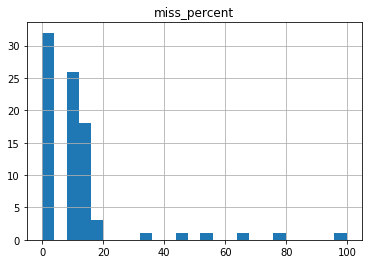

In [6]:
azdias_stats.hist(column = 'miss_percent', bins = 25 )

Text(0,0.5,'Features')

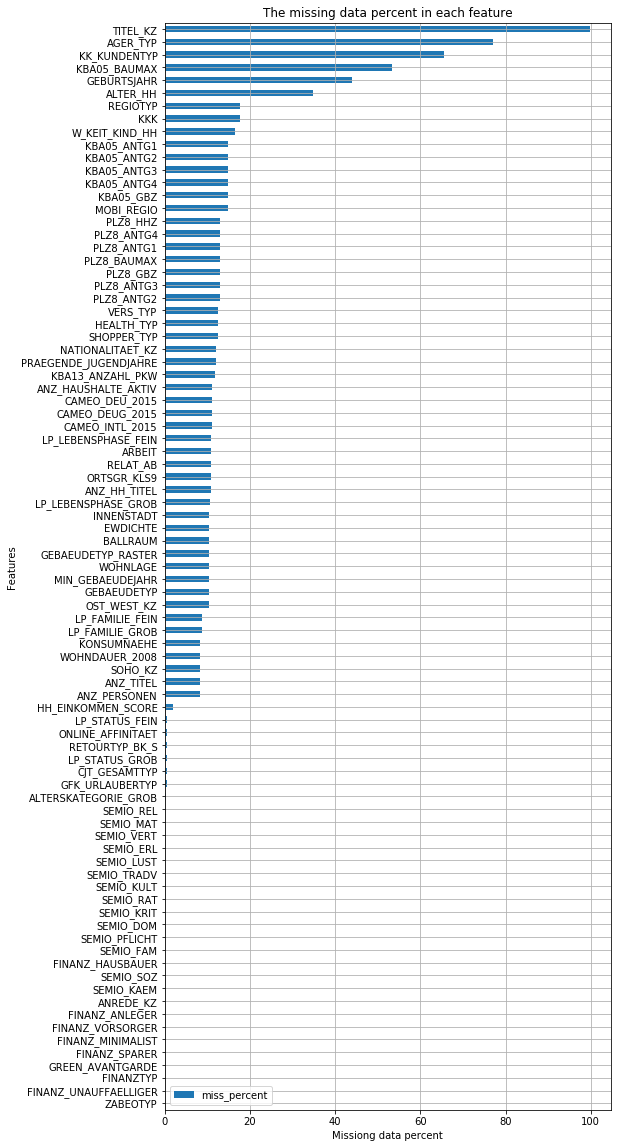

In [7]:
# Investigate patterns in the amount of missing data in each column.
azdias_plot= azdias_stats.sort_values('miss_percent', ascending=True)
azdias_plot.plot.barh(x='attribute', y='miss_percent', figsize=(8, 20), grid=True)
plt.title("The missing data percent in each feature")
plt.xlabel("Missiong data percent")
plt.ylabel("Features")


In [8]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
drop_col_threshold = 30
feature_to_drop= azdias_stats[azdias_stats['miss_percent'] >= drop_col_threshold]
feature_to_drop.head(10)

,attribute,miss_count,miss_percent
40,TITEL_KZ,889061,99.757636
0,AGER_TYP,685843,76.955435
47,KK_KUNDENTYP,584612,65.596749
64,KBA05_BAUMAX,476524,53.468668
11,GEBURTSJAHR,392318,44.020282
43,ALTER_HH,310267,34.813699


In [9]:
# removed data due to lots missing data in the column
azdias.drop(feature_to_drop.attribute, axis=1, inplace = True) 
azdias.shape

(891221, 79)

In [10]:
# condition to find target atrribute in feat_info
removed_condition = feat_info['attribute'].isin(feature_to_drop.attribute.tolist())
feat_info_removed_outlier=feat_info.loc[~removed_condition]


In [11]:
#Check last step's result
drop_list=feature_to_drop.attribute.tolist()
feat_info_removed_outlier.loc[feat_info_removed_outlier['attribute'].isin(drop_list)]

,attribute,information_level,type,missing_or_unknown


In [12]:
def Check_value_in_Nan_list(azdias,feat_info,count_name):
    '''Input: 
       count_name: one exited feature name
    '''
    if count_name in azdias.columns.tolist():
        print(azdias[count_name].value_counts()) 
        print(feat_info[feat_info['attribute'] == count_name].head())
    else:
        print("{} doesn't exist in azdias".format(count_name))

Check_value_in_Nan_list(azdias,feat_info,'ANREDE_KZ')

2.0    465305
1.0    425916
Name: ANREDE_KZ, dtype: int64
   attribute information_level         type missing_or_unknown
2  ANREDE_KZ            person  categorical             [-1,0]


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)
### The amount of missing data in each column
There are missing data in 57 columns. Features has 3 groups for a number of NaNs
* Group 1 has a few NaNs (<10%) 
* Group 2 has a small number of NaNs (<30%)
* Group 3 has a large number of NaNs (>=30%)


### Patterns in missing values
The features in group 1, 2 are heavily weighted in the records less than 30% missing percentage , part of which share very similar pattern: all sub-features that belong to the same category can have the missing data simultaneously. for example: CAMEO_INTL_2015	, CAMEO_DEU_2015, CAMEO_DEUG_2015 have the same percentage of missing values. They belongs to the same sub-features. they may miss data simultaneously.
 
### Remove column:
KK_KUNDENTYP column is removed from the dataset. KK_KUNDENTYP can be identified as outliers as clearly shown by the histogram distribution. Its missing percentage is 65.6%.   we can just simply rule out it in further data processing. 

Six features with missing percentage above 30% are removed. In descending order, they are: TITEL_KZ (99.76%), AGER_TYP (76.96%), KK_KUNDENTYP ( 65.6%), KBA05_BAUMAX ( 53.47%),GEBURTSJAHR (44.02%), ALTER_HH (34.81%). They are identified as outliers as clearly shown by the histogram distribution. In further data processing, we can rule out these features. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

Text(0.5,1,'The number of  missing row data ')

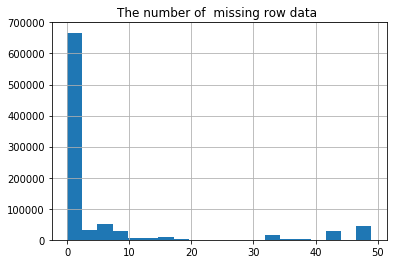

In [13]:
# How much data is missing in each row of the dataset?
missing_row_data = azdias.isnull().sum(axis=1)
missing_row_data.hist(bins = 20)
plt.title("The number of  missing row data " )

In [14]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
"""
From examing the chart above, it appears there are a large group of rows with less than 20 missing values 
and a second group of rows with more than 30 missing values. So the threshold will be 30.
"""
row_thereshold = 30
#count NaN by row, set condition that is less than row_thereshold
condition = azdias.isnull().sum(axis=1) < row_thereshold
#print(azdias.isnull().sum(axis=1) < row_thereshold)
azdias_below30 = azdias[condition]
azdias_above30 = azdias[~condition]

azdias_below30.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,4.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,1.0,1.0,3.0,3.0,3.0,4.0,1.0,3.0,2.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,1.0,3.0,4.0,4.0,2.0,4.0,2.0,2.0,6.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,2.0,4.0,2.0,4.0,2.0,3.0,5.0,4.0,1.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0
10,3.0,2.0,1.0,2.0,2.0,5.0,3.0,1.0,5.0,6.0,...,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0


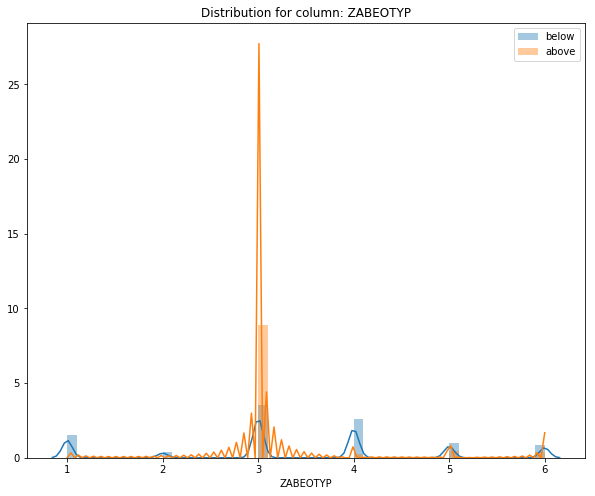

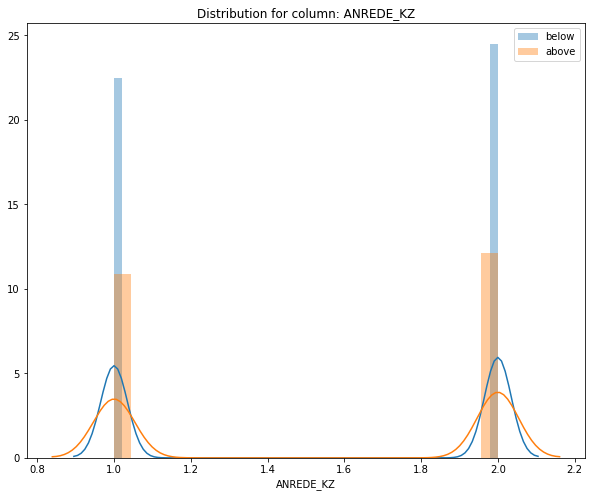

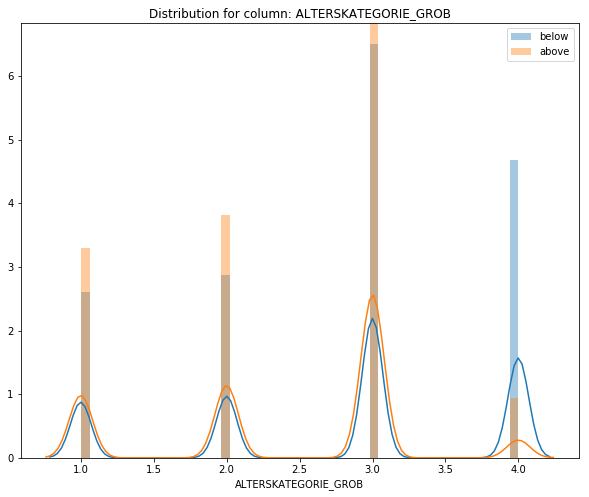

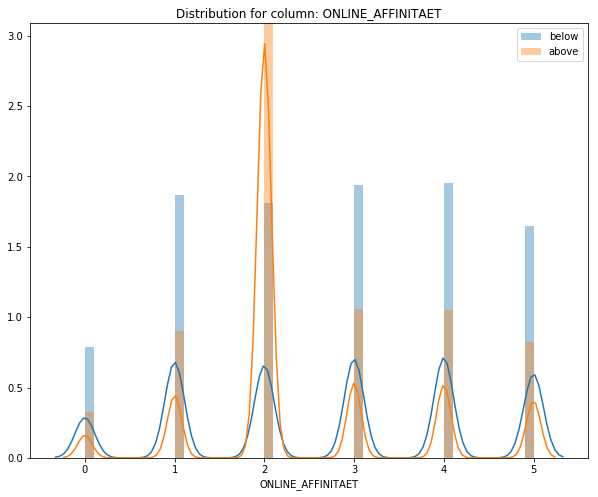

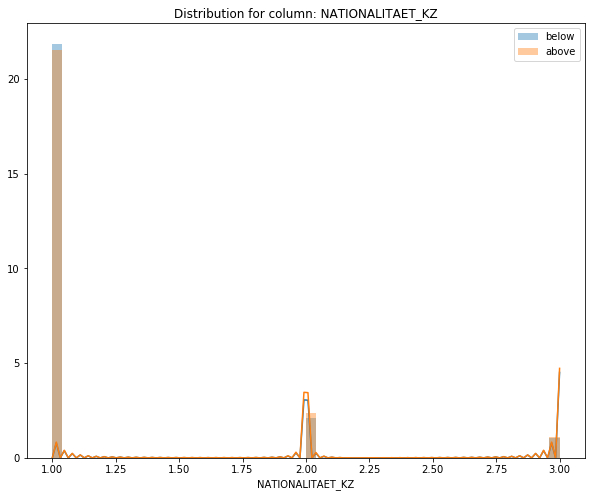

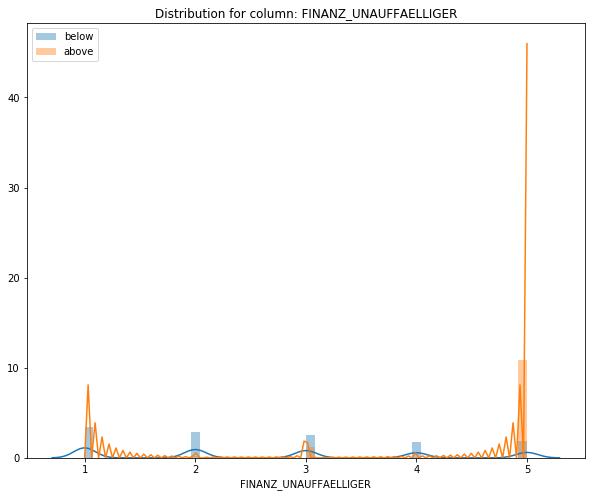

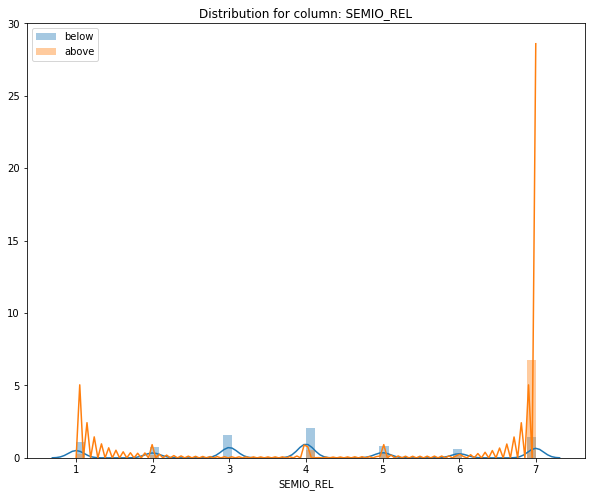

In [15]:
selected_features =['ZABEOTYP','ANREDE_KZ','ALTERSKATEGORIE_GROB',\
    'ONLINE_AFFINITAET', 'NATIONALITAET_KZ' ,'FINANZ_UNAUFFAELLIGER','SEMIO_REL']
for i, col in enumerate(selected_features):
    plt.figure(figsize=(10,8))
    sns.distplot(azdias_below30[col][azdias_below30[col].notnull()].astype(float), label='below')
    sns.distplot(azdias_above30[col][azdias_above30[col].notnull()].astype(float), label='above')
    plt.title('Distribution for column: {}'.format(col))
    plt.legend();

In [16]:
# prepare feature distribution data for analysis
azdias_below30_stat= azdias_below30[selected_features][azdias_below30[selected_features].notnull()].describe().T
azdias_below30_stat.columns=['count_b','mean_b','std_b','min_b','25%_b','50%_b','75%_b','max_b']
features = azdias_below30_stat.index.tolist()
azdias_below30_stat.insert(0,'feature',features)
azdias_above30_stat= azdias_above30[selected_features][azdias_above30[selected_features].notnull()].describe().T
azdias_above30_stat.columns=['count_a','mean_a','std_a','min_a','25%_a','50%_a','75%_a','max_a']
features = azdias_above30_stat.index.tolist()
azdias_above30_stat.insert(0,'feature',features)
azdias_stat=azdias_below30_stat.merge(azdias_above30_stat,on='feature')
azdias_stat.head(15)

,feature,count_b,mean_b,std_b,min_b,25%_b,50%_b,75%_b,max_b,count_a,mean_a,std_a,min_a,25%_a,50%_a,75%_a,max_a
0,ZABEOTYP,798061.0,3.378585,1.407776,1.0,3.0,3.0,4.0,6.0,93160.0,3.224109,0.711417,1.0,3.0,3.0,3.0,6.0
1,ANREDE_KZ,798061.0,1.521485,0.499538,1.0,1.0,2.0,2.0,2.0,93160.0,1.527351,0.499254,1.0,1.0,2.0,2.0,2.0
2,ALTERSKATEGORIE_GROB,795258.0,2.795412,1.018409,1.0,2.0,3.0,4.0,4.0,93082.0,2.430889,0.868609,1.0,2.0,3.0,3.0,4.0
3,ONLINE_AFFINITAET,793316.0,2.732974,1.555711,0.0,1.0,3.0,4.0,5.0,93051.0,2.406412,1.150080,0.0,2.0,2.0,3.0,5.0
4,NATIONALITAET_KZ,764143.0,1.168530,0.474722,1.0,1.0,1.0,1.0,3.0,18763.0,1.183499,0.489045,1.0,1.0,1.0,1.0,3.0
5,FINANZ_UNAUFFAELLIGER,798061.0,2.658348,1.399530,1.0,1.0,2.0,4.0,5.0,93160.0,4.722993,0.741143,1.0,5.0,5.0,5.0,5.0
6,SEMIO_REL,798061.0,3.994567,1.910502,1.0,3.0,4.0,5.0,7.0,93160.0,6.348347,1.523044,1.0,7.0,7.0,7.0,7.0


In [17]:
# find out the  feature distribution different in azdias_above30 is greater than 1 standard deviation of azdias_below30.

condition=(azdias_stat['mean_a']-azdias_stat['mean_b'])/azdias_stat['std_b'] > 1
azdias_stat.loc[condition,['feature','mean_b','mean_a']].head()

,feature,mean_b,mean_a
5,FINANZ_UNAUFFAELLIGER,2.658348,4.722993
6,SEMIO_REL,3.994567,6.348347


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)


Users have 3 groups for a number of NaNs in a row.
* Group 1 has a few NaNs ( in 0~10 columns per row) 
* Group 2 has a small number of NaNs (in 10~30 columns per row)
* Group 3 has a large number of NaNs (more than 30 columns per row)

The following features distribution in subset with lots of missing values looks similar with  one in subset with few or no missing values base above analysis.
  - ZABEOTYP
  - ANREDE_KZ
  - ALTERSKATEGORIE_GROB
  - ONLINE_AFFINITAET
  - NATIONALITAET_KZ 
  
The following features distribution in subset with lots of missing values looks much different than  one in subset with few or no missing values.
  - FINANZ_UNAUFFAELLIGER: UNAUFFAELLIGER means inconspicuous; the outlier spike in "5" buckets
  - SEMIO_REL: the outlier spike in "7" buckets that means lowest affinity associated with personality
  
Therefore, the statistics suggest treat these two populations are quite distinct from each other. In the following analysis, we will seperate the data with row missing values above the threshold to a dataset, and only focus on studying the majority group with small or few missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [18]:
# How many features are there of each data type?
print(feat_info_removed_outlier['type'].value_counts())

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64


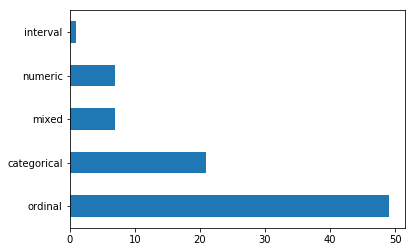

In [19]:
feat_info['type'].value_counts().plot(kind='barh');

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [20]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_list=feat_info_removed_outlier.loc[feat_info['type'] == 'categorical', 'attribute'].tolist()
categorical_list
azdias[categorical_list].head(10)

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
0,1.0,2.0,4.0,10.0,0,2.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
1,2.0,5.0,1.0,10.0,0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5.0,8.0,W,8,8A
2,2.0,3.0,1.0,10.0,1,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5.0,1.0,W,4,4C
3,2.0,2.0,6.0,1.0,0,NaN,NaN,9.0,4.0,1.0,1.0,0.0,1.0,3.0,1.0,W,2,2A
4,1.0,5.0,5.0,5.0,0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,2.0,4.0,1.0,W,6,6B
5,2.0,2.0,2.0,1.0,0,1.0,1.0,4.0,2.0,1.0,0.0,0.0,2.0,4.0,1.0,W,8,8C
6,2.0,5.0,4.0,12.0,0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,4.0,1.0,W,4,4A
7,1.0,3.0,5.0,9.0,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,8.0,W,2,2D
8,1.0,3.0,6.0,3.0,1,1.0,1.0,10.0,5.0,1.0,3.0,0.0,2.0,6.0,3.0,W,1,1A
9,2.0,4.0,1.0,12.0,1,1.0,1.0,3.0,2.0,1.0,3.0,0.0,2.0,4.0,3.0,W,1,1E


In [21]:
# Re-encode categorical variable(s) to be kept in the analysis.
#Get need encode features list with categorical type
non_numeric_binary_list = ['OST_WEST_KZ']
binary_list = ['ANREDE_KZ','GREEN_AVANTGARDE','SOHO_KZ','VERS_TYP']
multi_list = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN',
         'LP_FAMILIE_GROB','LP_STATUS_FEIN','LP_STATUS_GROB','NATIONALITAET_KZ',
        'SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015','CAMEO_DEU_2015']
No_need_encode_catlist=['GREEN_AVANTGARDE','SOHO_KZ']
Need_encode_catlist=list(set(categorical_list)-set(No_need_encode_catlist))
Need_encode_catlist


['ANREDE_KZ',
 'FINANZTYP',
 'SHOPPER_TYP',
 'OST_WEST_KZ',
 'GFK_URLAUBERTYP',
 'CAMEO_DEU_2015',
 'LP_STATUS_GROB',
 'ZABEOTYP',
 'LP_STATUS_FEIN',
 'VERS_TYP',
 'NATIONALITAET_KZ',
 'LP_FAMILIE_GROB',
 'LP_FAMILIE_FEIN',
 'GEBAEUDETYP',
 'CJT_GESAMTTYP',
 'CAMEO_DEUG_2015']

In [22]:
'''
   1 impute the most frequent value for the missing data in each column
'''
def impute_NaN_with_Most_freq_value(df, feature):
    '''
    input: 
            df: input dataframe to be imputed
            feature: the column from the dataframe you want to perform imputation
    '''
    # find most frequent category
    most_frequent_category = df.groupby([feature])[feature].count().sort_values(ascending=False).index[0]
    # replace NaN
    df[feature].fillna(most_frequent_category, inplace=True )
    
    
NaN_cols = azdias_below30.columns[azdias.isnull().any()].tolist()
for col in NaN_cols:
    impute_NaN_with_Most_freq_value(azdias_below30, col)
    print("replacing the NaN with most frequent value in column: ", col)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


replacing the NaN with most frequent value in column:  ALTERSKATEGORIE_GROB
replacing the NaN with most frequent value in column:  CJT_GESAMTTYP
replacing the NaN with most frequent value in column:  GFK_URLAUBERTYP
replacing the NaN with most frequent value in column:  HEALTH_TYP
replacing the NaN with most frequent value in column:  LP_LEBENSPHASE_FEIN
replacing the NaN with most frequent value in column:  LP_LEBENSPHASE_GROB
replacing the NaN with most frequent value in column:  LP_FAMILIE_FEIN
replacing the NaN with most frequent value in column:  LP_FAMILIE_GROB
replacing the NaN with most frequent value in column:  LP_STATUS_FEIN
replacing the NaN with most frequent value in column:  LP_STATUS_GROB
replacing the NaN with most frequent value in column:  NATIONALITAET_KZ
replacing the NaN with most frequent value in column:  PRAEGENDE_JUGENDJAHRE
replacing the NaN with most frequent value in column:  RETOURTYP_BK_S
replacing the NaN with most frequent value in column:  SHOPPER_TYP


In [23]:
'''
  2 Verify the result
'''
def check_NaN(df):
    print('How many NaN does all columns of the current dataset have ? : {} '.format(df.isnull().any().sum()))
check_NaN(azdias_below30)

How many NaN does all columns of the current dataset have ? : 0 


In [24]:
#one hot encoder for features with categorical 
azdias_below30_encode=pd.get_dummies(azdias_below30, prefix=Need_encode_catlist, columns=Need_encode_catlist )

In [25]:
#Verify OST_WEST_KZ reencoding:
print(azdias_below30_encode[['OST_WEST_KZ_O', 'OST_WEST_KZ_W']].head())
azdias_below30_encode[['OST_WEST_KZ_O', 'OST_WEST_KZ_W']].describe()

   OST_WEST_KZ_O  OST_WEST_KZ_W
1              0              1
2              0              1
3              0              1
4              0              1
5              0              1


,OST_WEST_KZ_O,OST_WEST_KZ_W
count,798061.000000,798061.000000
mean,0.211188,0.788812
std,0.408152,0.408152
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,1.000000
max,1.000000,1.000000


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Features with one-hot encoding in azdias
There are 21 features with categorical type. The "OST_WEST_KZ" is the only one binary categorical variable with non-numeric values, and the rest are multi-categorical variables. KK_KUNDENTYP and AGER_TYP are dropped in cleaning data steps due to missing data in most of users.

The only feature value is a non-numeric  categorical. This  need to be re-encoded the values as numbers or created a dummy variable
  - OST_WEST_KZ (O: East, W: West)
  
The following features value is a binary categorical:
 - ANREDE_KZ  (1: male, 2: female) excluding unknown -1 and can't be det 0
 - GREEN_AVANTGARDE  (0: not a member, 1: member)
 - SOHO_KZ (0: no small office, 1: small ofice), -1 unknown
 - VERS_TYP (1: social-safety, 2: individ)
 
The following features value is a muti-categorical:
 - LP_FAMILIE_FEIN
 - GEBAEUDETYP
 - LP_STATUS_FEIN
 - LP_FAMILIE_GROB
 - NATIONALITAET_KZ
 - ZABEOTYP
 - SHOPPER_TYP
 - CJT_GESAMTTYP
 - CAMEO_DEU_2015
 - LP_STATUS_GROB
 - GFK_URLAUBERTYP
 - CAMEO_DEUG_2015
 - TITEL_KZ

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [26]:
def create_feature(df,source_feature, map_dict):
    '''
    Input:
     df: source dataframe
     source_feature: one source feature that is data source for new feature. It doesn't support a mutliple features.
     map_dict: It includes the mapping dictionary between the data of source feature and new feature
    return:
     new_df: the new df include new feature data after convert data based on source_feature
    '''
    new_df = df[source_feature].astype(np.int).replace(map_dict)
    return new_df 

In [27]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Assess mix variables
mix_list=feat_info_removed_outlier.loc[feat_info['type'] == 'mixed', 'attribute'].tolist()
# Investigate "PRAEGENDE_JUGENDJAHRE" 
PRAEGENDE_JUGENDJAHRE_decade_mapping = {
    1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 
    9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6
}
azdias_below30_encode['PRAEGENDE_JUGENDJAHRE_DECADE'] = create_feature(azdias_below30_encode,'PRAEGENDE_JUGENDJAHRE', 
                                                                       PRAEGENDE_JUGENDJAHRE_decade_mapping)

#0 for mainstream, and 1 for avantgarde
PRAEGENDE_JUGENDJAHRE_movement_mapping = {
    1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 
    9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1
}
azdias_below30_encode['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = create_feature(azdias_below30_encode,'PRAEGENDE_JUGENDJAHRE', 
                                                                       PRAEGENDE_JUGENDJAHRE_movement_mapping)
mixed_categorical_list=['PRAEGENDE_JUGENDJAHRE_DECADE','PRAEGENDE_JUGENDJAHRE_MOVEMENT']


In [28]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_below30_encode['CAMEO_INTL_2015_WEALTH'] = azdias_below30_encode['CAMEO_INTL_2015'].astype(float).apply(lambda x: np.floor(x / 10))
azdias_below30_encode['CAMEO_INTL_2015_LIFE_STAGE'] = azdias_below30_encode['CAMEO_INTL_2015'].astype(float).apply(lambda x: (x % 10)) 
mixed_ordinal_list=['CAMEO_INTL_2015_WEALTH','CAMEO_INTL_2015_LIFE_STAGE']



In [29]:
# sanity check on PRAEGENDE_JUGENDJAHRE mapping
check_NaN(azdias_below30_encode)
azdias_below30_encode[['CAMEO_INTL_2015', 'CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_LIFE_STAGE']].head()

How many NaN does all columns of the current dataset have ? : 0 


,CAMEO_INTL_2015,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
1,51,5.0,1.0
2,24,2.0,4.0
3,12,1.0,2.0
4,43,4.0,3.0
5,54,5.0,4.0


In [30]:
Check_value_in_Nan_list(azdias,feat_info_removed_outlier,'WOHNLAGE')

3.0    249719
7.0    169318
4.0    135973
2.0    100376
5.0     74346
1.0     43918
8.0     17473
0.0      6950
Name: WOHNLAGE, dtype: int64
   attribute information_level   type missing_or_unknown
56  WOHNLAGE          building  mixed               [-1]


In [31]:
# Rural: Rural -> 1.0, Not Rural -> 2.0
WOHNLAGE_rural_mapping = {
    0: 2, 1: 2,  2: 2,  3: 2,
    4: 2, 5: 2,  7: 1,  8: 1
}
azdias_below30_encode['WOHNLAGE_RURAL'] = create_feature(azdias_below30_encode,'WOHNLAGE', WOHNLAGE_rural_mapping)
mixed_categorical_list.append('WOHNLAGE_RURAL')
# Neighborhood quality, Very good neighborhood -> 6.0, Good neighborhood -> 5.0, Average neighborhood -> 4.0, 
# Poor neighborhood -> 3.0, Very poor neighborhood -> 2.0, Unknown -> 1.0
WOHNLAGE_neighborhood_mapping = {
    0: 1, 1: 6, 2: 5, 3: 4,
    4: 3, 5: 2, 7: 1, 8: 1
}
azdias_below30_encode['WOHNLAGE_NEIGHBORHOOD'] = create_feature(azdias_below30_encode,'WOHNLAGE', WOHNLAGE_neighborhood_mapping)
mixed_ordinal_list.append('WOHNLAGE_NEIGHBORHOOD')

In [32]:
Check_value_in_Nan_list(azdias,feat_info_removed_outlier,'PLZ8_BAUMAX')

1.0    499550
5.0     97333
2.0     70407
4.0     56684
3.0     50732
Name: PLZ8_BAUMAX, dtype: int64
      attribute information_level   type missing_or_unknown
79  PLZ8_BAUMAX    macrocell_plz8  mixed             [-1,0]


In [33]:
# Investigate "PLZ8_BAUMAX", It is already　the ordinal feature
# 1-4   as 1-4 (homes),  5   as 0 
PLZ8_BAUMAX_homes_mapping = {
    1: 1, 2: 2, 3: 3,
    4: 4, 5: 0
}

# 1-4 as 0 (non-business),    5 as 1(business)
PLZ8_BAUMAX_business_mapping = {
    1: 0, 2: 0, 3: 0,
    4: 0, 5: 1
}
azdias_below30_encode['PLZ8_BAUMAX_HOMES'] = create_feature(azdias_below30_encode,'PLZ8_BAUMAX', PLZ8_BAUMAX_homes_mapping)
azdias_below30_encode['PLZ8_BAUMAX_BUSINESS'] = create_feature(azdias_below30_encode,'PLZ8_BAUMAX', PLZ8_BAUMAX_business_mapping)
mixed_ordinal_list.append('PLZ8_BAUMAX_BUSINESS')
mixed_categorical_list.append('PLZ8_BAUMAX_BUSINESS')


In [34]:
#categorical convert to one hot variable
Not_need_binary_encode_list=['PRAEGENDE_JUGENDJAHRE_MOVEMENT','PLZ8_BAUMAX_BUSINESS']
Need_binary_encode_list=list(set(mixed_categorical_list)-set(Not_need_binary_encode_list))
azdia_mixed_OHE=pd.get_dummies(azdias_below30_encode[Need_binary_encode_list].astype(np.object))
azdia_mixed_OHE.head()

,PRAEGENDE_JUGENDJAHRE_DECADE_1,PRAEGENDE_JUGENDJAHRE_DECADE_2,PRAEGENDE_JUGENDJAHRE_DECADE_3,PRAEGENDE_JUGENDJAHRE_DECADE_4,PRAEGENDE_JUGENDJAHRE_DECADE_5,PRAEGENDE_JUGENDJAHRE_DECADE_6,WOHNLAGE_RURAL_1,WOHNLAGE_RURAL_2
1,0,0,0,0,0,1,0,1
2,0,0,0,0,0,1,0,1
3,0,0,0,1,0,0,1,0
4,0,0,0,1,0,0,0,1
5,0,1,0,0,0,0,1,0


In [35]:
# Ordinal features are converted into numeric.
azdias_below30_encode.loc[:,mixed_ordinal_list] = azdias_below30_encode[mixed_ordinal_list].astype(np.float)
# Drop the four original features
azdias_below30_encode.drop(mix_list, axis = 1, inplace = True)
print("\n The new dataset dimension is: {}".format(azdias_below30_encode.shape))


 The new dataset dimension is: (798061, 199)


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)


#### The mixed features are listed as follows:
 - LP_LEBENSPHASE_FEIN: Life stage, fine scale
 - LP_LEBENSPHASE_GROB: Life stage, rough scale
 - PRAEGENDE_JUGENDJAHRE: Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
 - WOHNLAGE: Neighborhood quality (or rural flag)
 - CAMEO_INTL_2015: German CAMEO: Wealth / Life Stage Typology, mapped to international code
 - PLZ8_BAUMAX: Most common building type within the PLZ8 region
 
** The following features are selected and converted: **
 - PRAEGENDE_JUGENDJAHRE is converted into two categorical features (movement or decade)
 - CAMEO_INTL_2015 is converted into two oridnal features (wealth or life stage)
 - WOHNLAGE is converted into categorical or ordinal features (rural or neighborhood quality)
 - PLZ8_BAUMAX:  is converted into categorical or ordinal features (homes or business quality)

** The following features are not selected. **
 - LP_LEBENSPHASE_FEIN: Life stage is already included by CAMEO_INTL_2015
 - LP_LEBENSPHASE_GROB: Life stage is already included by CAMEO_INTL_2015


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [36]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
# This steps is done in previous task.



In [37]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_below30_encode=azdias_below30_encode.join(azdia_mixed_OHE)
print(azdias_below30_encode.shape)
for c in azdias_below30_encode.columns:
    print(c)


(798061, 207)
ALTERSKATEGORIE_GROB
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
GREEN_AVANTGARDE
HEALTH_TYP
RETOURTYP_BK_S
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
SOHO_KZ
ANZ_PERSONEN
ANZ_TITEL
HH_EINKOMMEN_SCORE
W_KEIT_KIND_HH
WOHNDAUER_2008
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
KONSUMNAEHE
MIN_GEBAEUDEJAHR
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_GBZ
BALLRAUM
EWDICHTE
INNENSTADT
GEBAEUDETYP_RASTER
KKK
MOBI_REGIO
ONLINE_AFFINITAET
REGIOTYP
KBA13_ANZAHL_PKW
PLZ8_ANTG1
PLZ8_ANTG2
PLZ8_ANTG3
PLZ8_ANTG4
PLZ8_HHZ
PLZ8_GBZ
ARBEIT
ORTSGR_KLS9
RELAT_AB
ANREDE_KZ_1.0
ANREDE_KZ_2.0
FINANZTYP_1.0
FINANZTYP_2.0
FINANZTYP_3.0
FINANZTYP_4.0
FINANZTYP_5.0
FINANZTYP_6.0
SHOPPER_TYP_0.0
SHOPPER_TYP_1.0
SHOPPER_TYP_2.0
SHOPPER_TYP_3.0
OST_WEST_KZ_O
OST_WEST_KZ_W
GFK_URLAUBERTYP_1.0
GFK_URLAUBERTYP_2.0
GFK_URLAUBERTYP_3.0
GFK_URL

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [38]:
def clean_data(df, feat_info, df_drop_cols_sync=None ):
    """
    Perform feature trimming, re-encoding, and engineering for demographicsdata
    INPUT: 
        df: Demographics DataFrame and Feature infomation DataFrame with a count of nan.
        df_drop_cols_sync: It will used in the other dataset that need to compared with the cleaned demographics DataFrame
    OUTPUT: 
       Trimmed and cleaned demographics DataFrame
    """

    azdias=df
    # Identify missing or unknown data values and convert them to NaNs.
    """
    if azdias.columns match feat_info.columns and azdias.column.value is in the feat_info.missing_or_unknown,
       replace old with np.nan
    """
    for ac in azdias.columns:
        NaN_list =feat_info.loc[feat_info['attribute'] == ac,'missing_or_unknown'].tolist()[0]
        NaN_list_str = NaN_list.strip('[]').split(',')
        if NaN_list_str[0] !='':
            # some feature may be float format, so add float format string for number value except the string value
            try:
                NaN_list_tmp=[]
                for i in NaN_list_str:
                    if pd.api.types.is_number(eval(i)):
                        NaN_list_tmp.append(str(float(i)))
            except:
                # if eval find that i is a string, the except part will bypass it.
                next
            NaN_list_str += NaN_list_tmp
            azdias.loc[azdias[ac].astype(str).isin(NaN_list_str),ac]=np.nan
            
            
            
    # remove selected columns and rows, ...
    # remove selected columns         
    # Perform an assessment of how much missing data there is in each column of the dataset.
    rec = []
    for column_name in azdias.columns:
        miss_count = azdias[column_name].isnull().sum(axis=0)
        miss_percent=miss_count/azdias.shape[0]
        rec.append([column_name,miss_count,miss_percent*100])
    azdias_stats = pd.DataFrame.from_records(rec, columns = ['attribute', 'miss_count','miss_percent'])  
    azdias_stats = azdias_stats.sort_values('miss_percent',axis=0, ascending = False )
    
    # Remove the outlier columns from the dataset. (You'll perform other data
    # engineering tasks such as re-encoding and imputation later.)

    if df_drop_cols_sync is not None:  
        #if the columns in adias is dropped , and they also must be dropped in the comparative dataset
        feature_to_drop = df_drop_cols_sync
    else:
        drop_col_threshold = 30
        feature_to_drop= azdias_stats.loc[azdias_stats['miss_percent'] >= drop_col_threshold]
        print("Drop these columns : {}".format(feature_to_drop.attribute.tolist()) )
        print(feature_to_drop.head(10))
    
    # removed data due to lots missing data in the column
    azdias.drop(feature_to_drop.attribute, axis=1, inplace = True) 
    # condition to find target atrribute in feat_info
    removed_condition = feat_info['attribute'].isin(feature_to_drop.attribute.tolist())
    feat_info_removed_outlier=feat_info.loc[~removed_condition]
    
    
    # remove selected  rows, ...
    """
    From examing the data, it appears there are a large group of rows with less than 20 missing values 
    and a second group of rows with more than 30 missing values. So the threshold will be 30.
    """
    row_thereshold = 30
    #count NaN by row, set condition that is less than row_thereshold
    condition = azdias.isnull().sum(axis=1) < row_thereshold
    azdias_below30 = azdias[condition]
    azdias_above30 = azdias[~condition]


    # select, re-encode, and engineer column values.
    # Assess categorical variables: which are binary, which are multi-level, and
    # which one needs to be re-encoded?
    categorical_list=feat_info_removed_outlier.loc[feat_info['type'] == 'categorical', 'attribute'].tolist()
    
    # Re-encode categorical variable(s) to be kept in the analysis.
    #Get need encode features list with categorical type
    non_numeric_binary_list = ['OST_WEST_KZ']
    binary_list = ['ANREDE_KZ','GREEN_AVANTGARDE','SOHO_KZ','VERS_TYP']
    multi_list = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN',
             'LP_FAMILIE_GROB','LP_STATUS_FEIN','LP_STATUS_GROB','NATIONALITAET_KZ',
            'SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015','CAMEO_DEU_2015']
    No_need_encode_catlist=['GREEN_AVANTGARDE','SOHO_KZ']
    Need_encode_catlist=list(set(categorical_list)-set(No_need_encode_catlist))
     
    #impute the most frequent value for the missing data in each column 
    NaN_cols = azdias_below30.columns[azdias.isnull().any()].tolist()
    for col in NaN_cols:
        impute_NaN_with_Most_freq_value(azdias_below30, col)
    
    #one hot encoder for features with categorical 
    azdias_below30_encode=pd.get_dummies(azdias_below30, prefix=Need_encode_catlist, columns=Need_encode_catlist )
    
    # Assess mix variables
    mix_list=feat_info_removed_outlier.loc[feat_info['type'] == 'mixed', 'attribute'].tolist()
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.                                                   
    # 1 stands for 40s, 2 for 50s, 3 for 60s, 4 for 70s, 5 for 80s and 6 for 90s                                            
    PRAEGENDE_JUGENDJAHRE_decade_mapping = {                                                                                
        1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4,                                                                             
        9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6                                                                             
    }                                                                                                                       
    azdias_below30_encode['PRAEGENDE_JUGENDJAHRE_DECADE'] = \
        create_feature(azdias_below30_encode,'PRAEGENDE_JUGENDJAHRE', PRAEGENDE_JUGENDJAHRE_decade_mapping)            
                                                                                                                            
    #0 for mainstream, and 1 for avantgarde                                                                                 
    PRAEGENDE_JUGENDJAHRE_movement_mapping = {                                                                              
        1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0,                                                                             
        9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1                                                                             
    }                                                                                                                       
    azdias_below30_encode['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = \
        create_feature(azdias_below30_encode,'PRAEGENDE_JUGENDJAHRE',PRAEGENDE_JUGENDJAHRE_movement_mapping)          
    mixed_categorical_list=['PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT']   
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.                                                                                                        
    azdias_below30_encode['CAMEO_INTL_2015_WEALTH'] = \
        azdias_below30_encode['CAMEO_INTL_2015'].astype(float).apply(lambda x: np.floor(x / 10))
    azdias_below30_encode['CAMEO_INTL_2015_LIFE_STAGE'] = \
        azdias_below30_encode['CAMEO_INTL_2015'].astype(float).apply(lambda x: (x % 10)) 
    mixed_ordinal_list=['CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_LIFE_STAGE']
    
    # Rural: Rural -> 1.0, Not Rural -> 2.0                                                                                                                                                     
    WOHNLAGE_rural_mapping = {                                                                                                      
        0: 2, 1: 2,  2: 2,  3: 2,                                                                                                   
        4: 2, 5: 2,  7: 1,  8: 1                                                                                                    
    }                                                                                                                               
    azdias_below30_encode['WOHNLAGE_RURAL'] = create_feature(azdias_below30_encode,'WOHNLAGE', WOHNLAGE_rural_mapping)              
    mixed_categorical_list.append('WOHNLAGE_RURAL')                                                                                 
    # Neighborhood quality, Very good neighborhood -> 6.0, Good neighborhood -> 5.0, Average neighborhood -> 4.0,                   
    # Poor neighborhood -> 3.0, Very poor neighborhood -> 2.0, Unknown -> 1.0                                                       
    WOHNLAGE_neighborhood_mapping = {                                                                                               
        0: 1, 1: 6, 2: 5, 3: 4,                                                                                                     
        4: 3, 5: 2, 7: 1, 8: 1                                                                                                      
    }                                                                                                                               
    azdias_below30_encode['WOHNLAGE_NEIGHBORHOOD'] = create_feature(azdias_below30_encode,'WOHNLAGE', WOHNLAGE_neighborhood_mapping)
    mixed_ordinal_list.append('WOHNLAGE_NEIGHBORHOOD')
    
    # Investigate "PLZ8_BAUMAX", It is already　the ordinal feature                                                                                                                                                
    # 1-4   as 1-4 (homes),  5   as 0                                                                                                
    PLZ8_BAUMAX_homes_mapping = {                                                                                                    
        1: 1, 2: 2, 3: 3,                                                                                                            
        4: 4, 5: 0                                                                                                                   
    }                                                                                                                                
                                                                                                                                     
    # 1-4 as 0 (non-business),    5 as 1(business)                                                                                   
    PLZ8_BAUMAX_business_mapping = {                                                                                                 
        1: 0, 2: 0, 3: 0,                                                                                                            
        4: 0, 5: 1                                                                                                                   
    }                                                                                                                                
    azdias_below30_encode['PLZ8_BAUMAX_HOMES'] = create_feature(azdias_below30_encode,'PLZ8_BAUMAX', PLZ8_BAUMAX_homes_mapping)      
    azdias_below30_encode['PLZ8_BAUMAX_BUSINESS'] = create_feature(azdias_below30_encode,'PLZ8_BAUMAX', PLZ8_BAUMAX_business_mapping)
    mixed_ordinal_list.append('PLZ8_BAUMAX_BUSINESS')                                                                                
    mixed_categorical_list.append('PLZ8_BAUMAX_BUSINESS')   

    #categorical convert to one hot variable                                                                                                                                 
    Not_need_binary_encode_list=['PRAEGENDE_JUGENDJAHRE_MOVEMENT','PLZ8_BAUMAX_BUSINESS']           
    Need_binary_encode_list=list(set(mixed_categorical_list)-set(Not_need_binary_encode_list))      
    azdia_mixed_OHE=pd.get_dummies(azdias_below30_encode[Need_binary_encode_list].astype(np.object))
    # Ordinal features are converted into numeric.
    azdias_below30_encode.loc[:,mixed_ordinal_list] = azdias_below30_encode[mixed_ordinal_list].astype(np.float)

    # Return the cleaned dataframe. 
       
    # Drop the four original features                             
    azdias_below30_encode.drop(mix_list, axis = 1, inplace = True)
    # Add one_hot featurs
    azdias_below30_encode=azdias_below30_encode.join(azdia_mixed_OHE)
    
    return azdias_below30_encode, azdias_above30,feature_to_drop
    
    

In [39]:
#verity clean_data
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')
#Clean the dataset.
azdias_processed,azdias_outlier, df_drop_cols_sync = clean_data(azdias, feat_info)
# number of population with high NaNs
azdias_NaN_count = azdias.shape[0] - azdias_processed.shape[0]

Drop these columns : ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
       attribute  miss_count  miss_percent
40      TITEL_KZ      889061     99.757636
0       AGER_TYP      685843     76.955435
47  KK_KUNDENTYP      584612     65.596749
64  KBA05_BAUMAX      476524     53.468668
11   GEBURTSJAHR      392318     44.020282
43      ALTER_HH      310267     34.813699


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [40]:
#sanity check
check_NaN(azdias_processed)
print(" number of population with high NaNs is {}".format(azdias_NaN_count))

How many NaN does all columns of the current dataset have ? : 0 
 number of population with high NaNs is 93160


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [41]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.



In [42]:
# Apply feature scaling to the general population demographics data.
scaler=MinMaxScaler()
azdias_scaled_np= scaler.fit_transform(azdias_processed)
#convert it to DataFrame
azdias_scaled=pd.DataFrame(data=azdias_scaled_np, index=azdias_processed.index, columns=azdias_processed.columns)



In [43]:
def scale_data(df, scaler):
    # Only transform data by using old fit
    scaled_np= scaler.transform(df)
    #convert it to DataFrame
    return pd.DataFrame(data=scaled_np, index=df.index, columns=df.columns)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

** answers **

The scaling features of pandas requires non-missing values in the columns. There are two ways to handle the missing value:
 - 1. drop rows with any missing values;
 - 2. use imputation method.

When the missing data in a column is more than 20% of total, the first one can be used. When the dataset contains the rows with missing value occupied less than 20% of the total population, the first one is not the optimal approach. So I use imputation method written by myself before the step of creating dummy variables, the missing values in each column have been replaced with the most frequenct value in the corresponding column. Next, I scaled each feature by using MinMaxScaler. Because some of feature are skewed.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [44]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(azdias_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

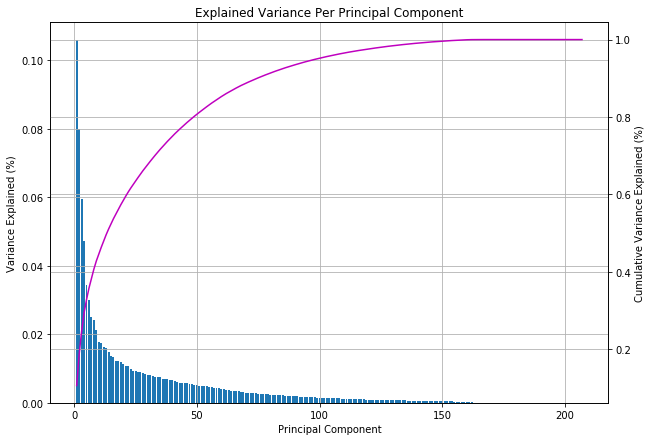

In [45]:
# Investigate the variance accounted for by each principal component.
def show_var_and_cumvar(pca):
    num_components = len(pca.explained_variance_ratio_)
    indx = np.arange(num_components) + 1 # start with 1
    variance_ratio = pca.explained_variance_ratio_
    
    plt.figure(figsize=(10, 7))

    cumulative_variance_ratio = np.cumsum(variance_ratio)

    plt.bar(indx, variance_ratio)  # add variance_ratio as first y axis, indx is used to x axis.
    plt.title('Explained Variance Per Principal Component')
    plt.ylabel("Variance Explained (%)")
    plt.xlabel("Principal Component")
    plt.grid(True)
    
    plt.twinx()  # add one axis for y axis, indx is used to x axis.
    plt.plot(indx, cumulative_variance_ratio, 'm')
    plt.ylabel("Cumulative Variance Explained (%)")
    
    plt.grid(True)
    plt.show()

show_var_and_cumvar(pca)


In [46]:
# Re-apply PCA to the data while selecting for number of components to retain.
def do_pca(df, n_com):
    pca_n =PCA(n_components=n_com)
    return pca_n, pca_n.fit_transform(df)
pca_n, np_azdias_scaled_pca_n = do_pca(azdias_scaled, 50)

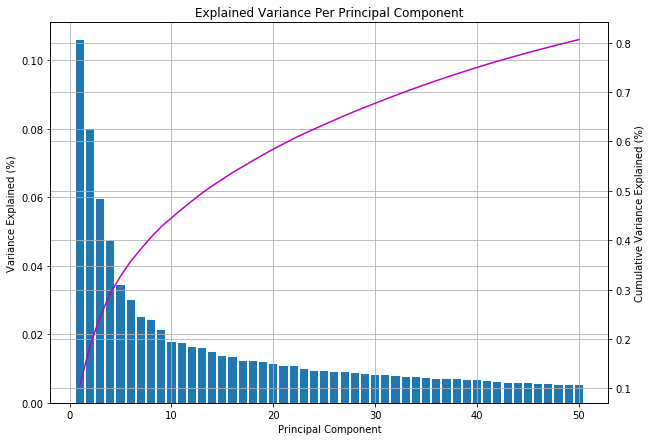

In [47]:
show_var_and_cumvar(pca_n)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)


** answer **

The plot shows that more than 80% of the variance can be explained by 50 features.  The remain features are flat decaying tail afterward.

This could be considered as a good stopping point where additonal components do not contribute much to the explained variance. Based on above justifications, 50 principal components will be retained in the following analysis.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [48]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def get_sorted_features(df, pca, n_comp):
    #from collections import OrderedDict
    features = df.columns.tolist()
    components = pca.components_[n_comp].tolist()
    weight_map = dict(zip(features, components))
    sorted_features = sorted(weight_map.items(), key=lambda x:x[1])
    return sorted_features

def plot_weights(sorted_features,n_comp):
    df_tmp = pd.DataFrame.from_records(sorted_features,columns=['Features' , 'Weights'])
    ax1=df_tmp.plot.barh(x='Features', y='Weights', figsize=(6, 50), grid=True)
    plt.ylabel('Features')
    plt.xlabel('Weights')
    plt.title('Weights for the ' + str(n_comp) + ' components')
    
    plt.show()
    
def show_weight_and_plot(df, pca, n_com):
    features = get_sorted_features(df, pca, n_com)
    for i in features[:3]:
        print(i) 
    for i in sorted(features, key=lambda x:x[1], reverse= True)[:3]:
        print(i) 
    plot_weights(features,n_com)

('LP_STATUS_GROB_1.0', -0.2782778214141837)
('CAMEO_INTL_2015_WEALTH', -0.17189161350816898)
('PLZ8_ANTG4', -0.16940280468839905)
('FINANZ_MINIMALIST', 0.1957009398496042)
('KBA05_ANTG1', 0.16744228006279727)
('WOHNLAGE_RURAL_1', 0.16014737156816025)


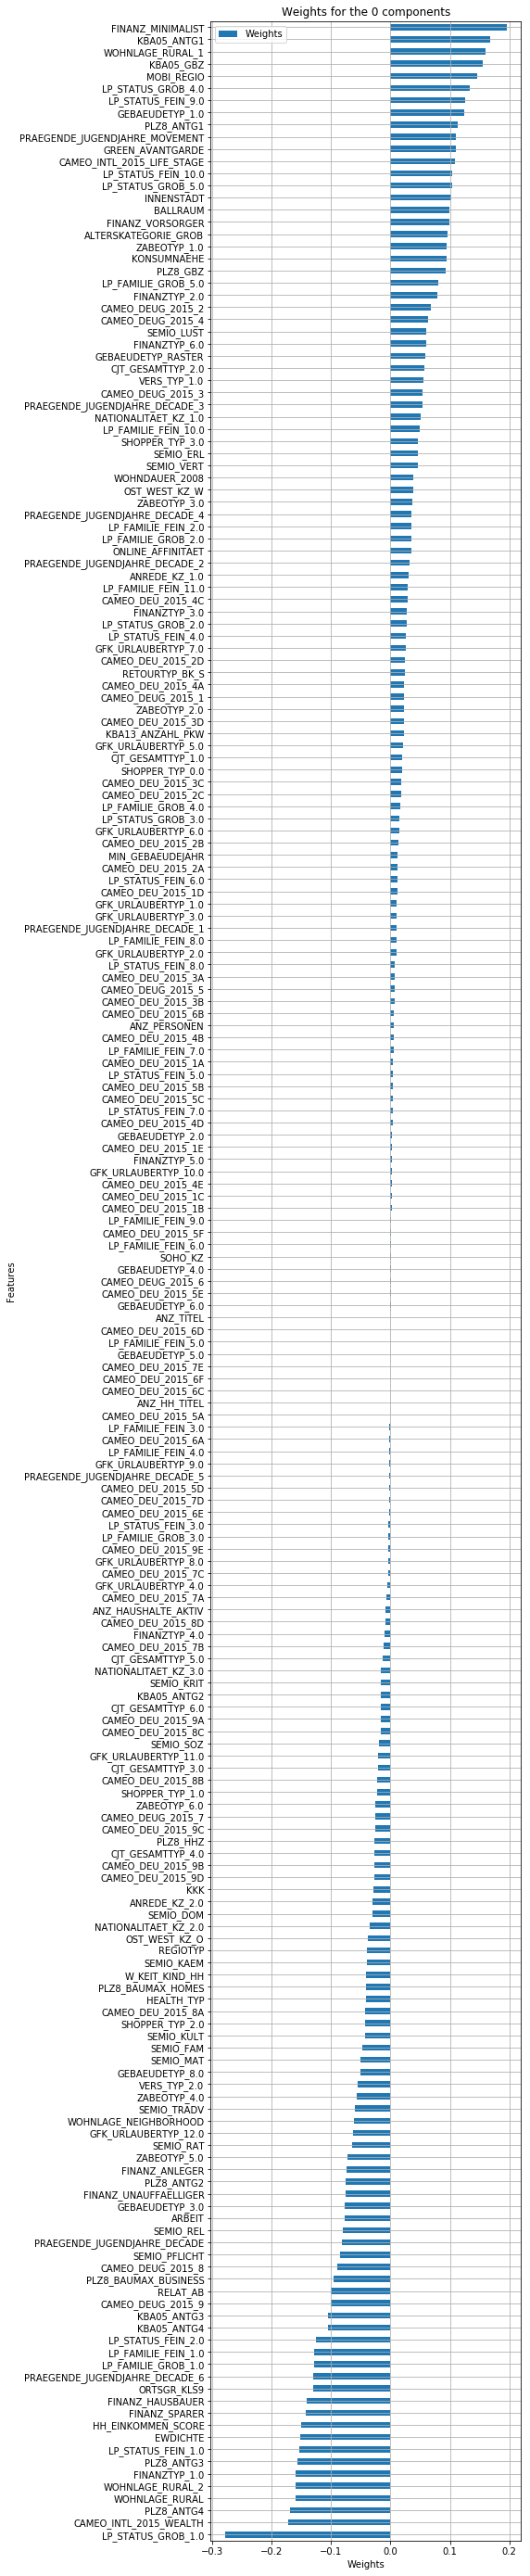

In [49]:
##### Map weights for the First principal  
show_weight_and_plot(azdias_scaled, pca_n, 0)

('ZABEOTYP_3.0', -0.27055822924658557)
('FINANZ_VORSORGER', -0.20204656016895106)
('ALTERSKATEGORIE_GROB', -0.20036186619381294)
('PRAEGENDE_JUGENDJAHRE_DECADE_6', 0.2515082818896564)
('FINANZ_SPARER', 0.22549533542267272)
('FINANZ_UNAUFFAELLIGER', 0.2069948223033233)


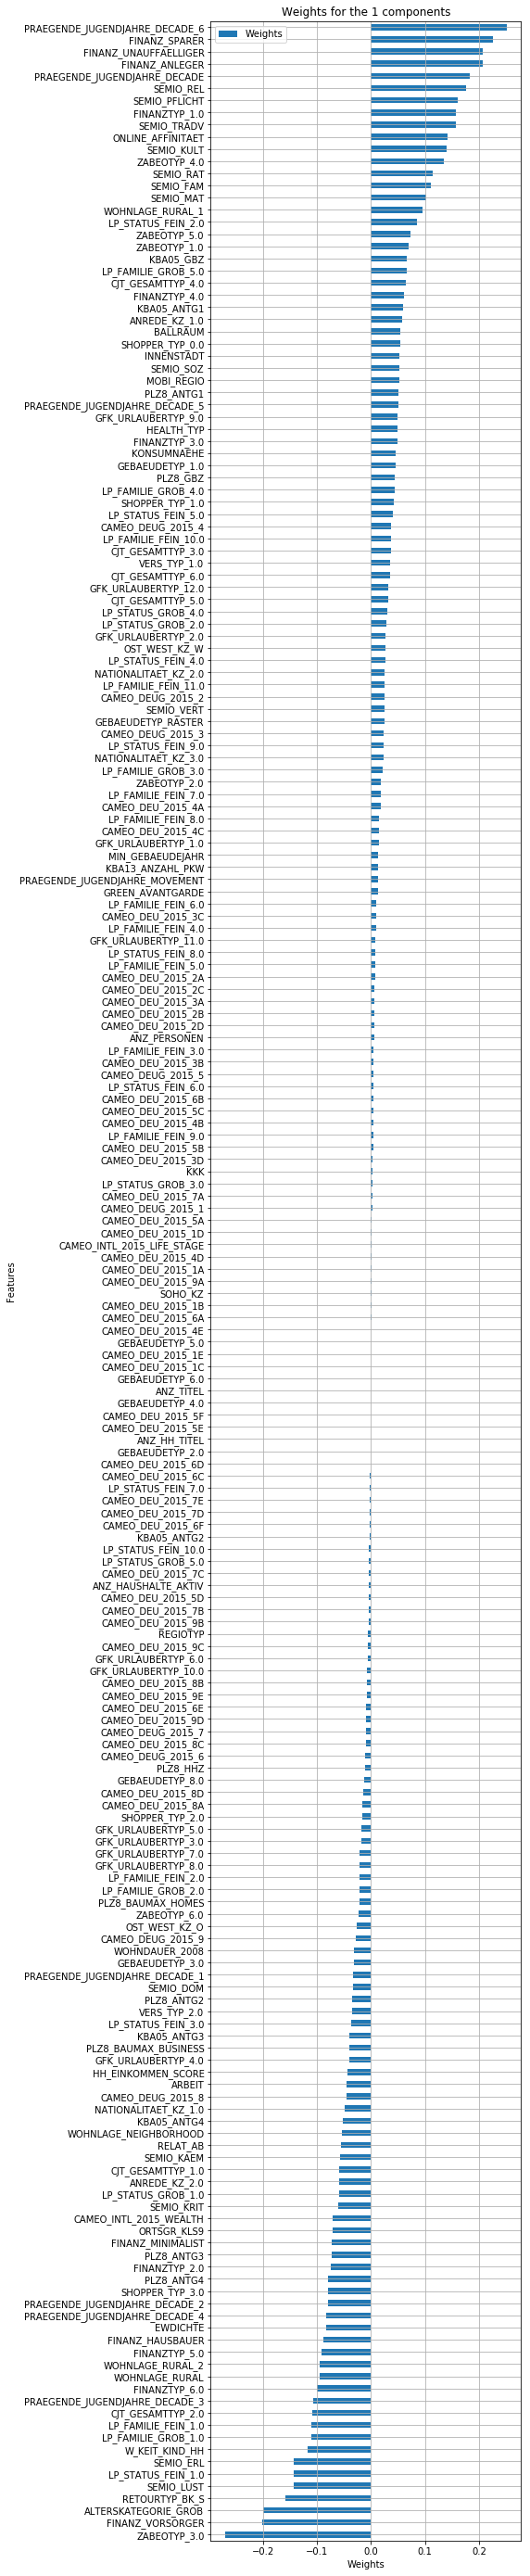

In [50]:
##### Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
show_weight_and_plot(azdias_scaled, pca_n, 1)

('ANREDE_KZ_2.0', -0.4525666709106429)
('SEMIO_KAEM', -0.24656267198036375)
('SEMIO_DOM', -0.20806248580539846)
('ANREDE_KZ_1.0', 0.4525666709106429)
('SEMIO_VERT', 0.26091472400676596)
('SEMIO_KULT', 0.21259759880866283)


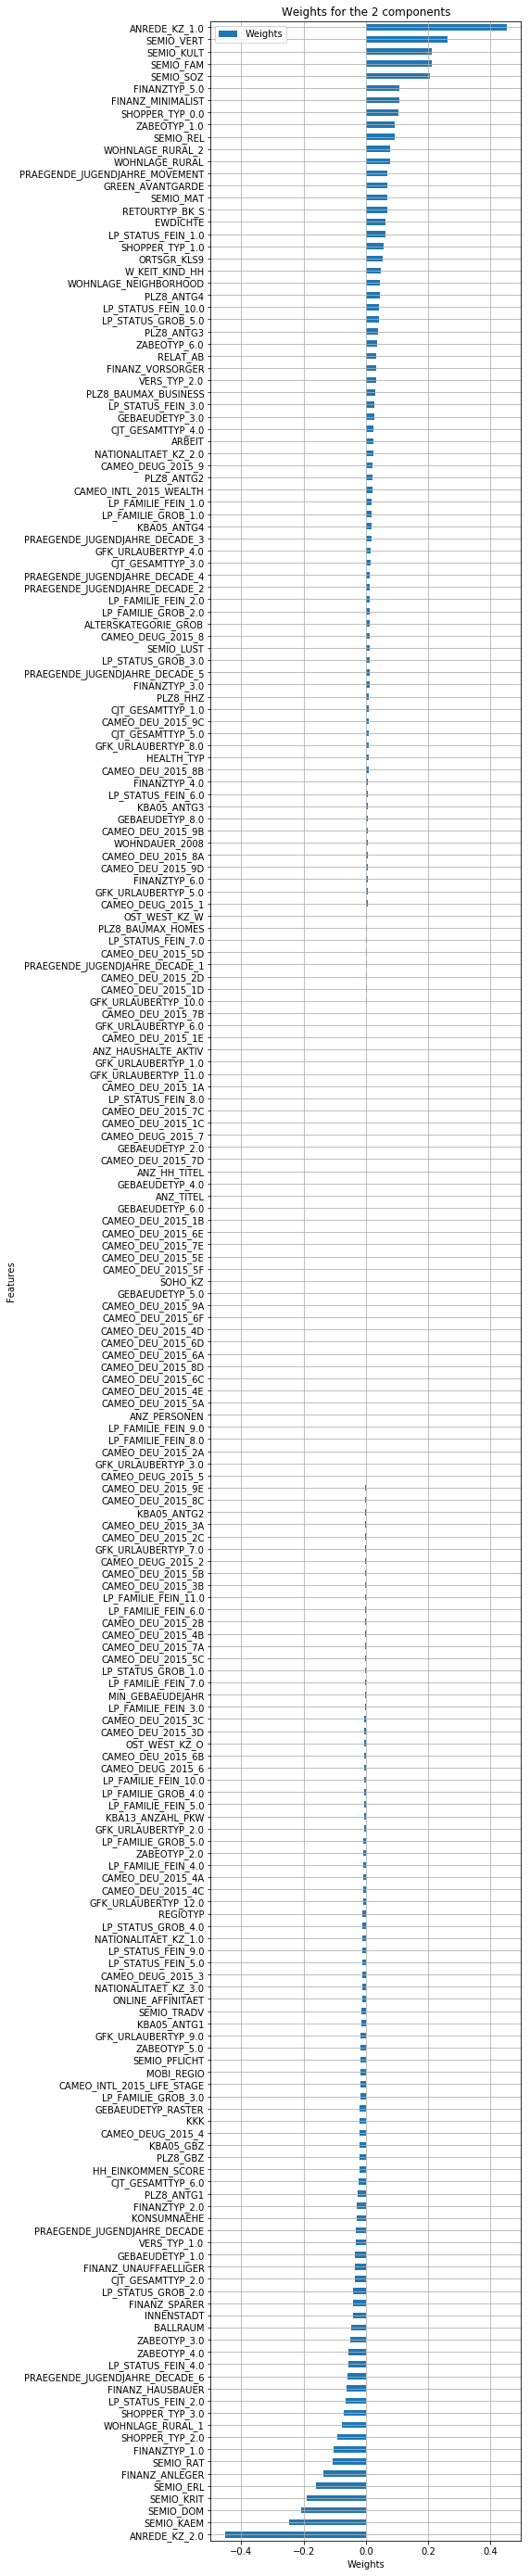

In [51]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
show_weight_and_plot(azdias_scaled, pca_n, 2)


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?) 


** answers **

### The first componet

 - Top 3 positive features 
   - FINANZ_MINIMALIST: Financial typology, MINIMALIST means low financial interest.
   - KBA05_ANTG1: Number of 1-2 family houses in the microcell      
   - WOHNLAGE_RURAL_1:rural flag
 - Top 3 negative features
   - LP_STATUS_GROB_1.0:  Social status, rough scale low-income earners, 1 means low-income earners.
   - CAMEO_INTL_2015_WEALTH: Wealth Typology, mapped to international code.
   - PLZ8_ANTG4:  Number of 10+ family houses in the PLZ8 region
   
  The first component means about middleclass life style and consuming habits.

### The second componet
 - Top 3 positive features
   - PRAEGENDE_JUGENDJAHRE_DECADE_6: person's youth , 6 for 90s  
   - FINANZ_SPARER: Financial typology, SPARER means sparer money
   - FINANZ_UNAUFFAELLIGER:  Financial typology,UNAUFFAELLIGER: inconspicuous
 - Top 3 negative features
   - ZABEOTYP_3.0: Energy consumption typology, 3 means fair supplied.
   - FINANZ_VORSORGER:  Financial typology, VORSORGER means be prepared.
   - ALTERSKATEGORIE_GROB: Estimated age based on given name analysis.
   
  The third component means about younth present year and their financial status.

### The third component
 - Top 3 positive features
   - ANREDE_KZ_1.0: Gender, 1 means male.
   - SEMIO_VERT: Personality typology, VERT means dreamful.
   - SEMIO_SOZ: Personality typology, SOZ means socially-minded.
 - Top 3 negative features
   - ANREDE_KZ_2.0: Gender, 2 means female.
   - SEMIO_KAEM: Personality typology, KAEM means combative attitude.
   - SEMIO_DOM: Personality typology, DOM means dominant-minded

  The third component means about Personality differences between male and female.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [52]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans

# run k-means clustering on the data and...
def model_fit(data,max_k_value):
    scores=[]
    centers=list(range(1,max_k_value))
    for i in centers:
        scores.append(get_score(i,data))
    return centers, scores    
    
# compute the average within-cluster distances.
def get_score(center,data):
    kmean=KMeans(n_clusters=center)
    model=kmean.fit(data)
    score=np.abs(model.score(data))
    return score
  

In [53]:
centers, scores = model_fit(np_azdias_scaled_pca_n,16)  

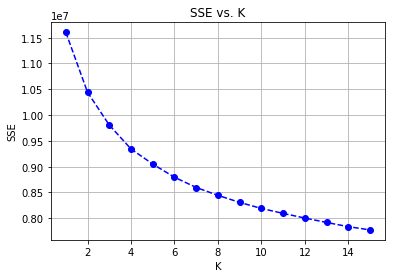

In [54]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
#elbow method
plt.plot(centers,scores, linestyle='--', marker='o', color='b');
plt.grid(True)
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [55]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
n_clusters = 8
km_n = KMeans(n_clusters = n_clusters)
km_model_n = km_n.fit(np_azdias_scaled_pca_n)


In [56]:
# convert ndarray to dataframe object
azdias_scaled_label = pd.DataFrame({"Cluster_ID": km_model_n.predict(np_azdias_scaled_pca_n)})
df_azdias_scaled_pca = pd.DataFrame(data = np_azdias_scaled_pca_n, \
                                    columns = ['Dim {}'.format(i) for i in range(1,len(pca_n.components_)+1)])
df_azdias_scaled_pca = pd.concat([df_azdias_scaled_pca, azdias_scaled_label],axis =1)
df_azdias_scaled_pca.head(10)

,Dim 1,Dim 2,Dim 3,Dim 4,Dim 5,Dim 6,Dim 7,Dim 8,Dim 9,Dim 10,...,Dim 42,Dim 43,Dim 44,Dim 45,Dim 46,Dim 47,Dim 48,Dim 49,Dim 50,Cluster_ID
0,-1.925805,1.170833,-1.100664,0.489932,0.346432,-0.475406,0.940579,-0.080815,-0.033822,-0.539304,...,-0.200369,0.454549,-0.444755,0.338002,0.325034,0.146425,-0.068598,0.445106,-0.258933,7
1,-0.145233,0.478826,-1.202919,0.940368,-1.495887,0.623947,0.195111,-0.016435,0.247235,0.933712,...,0.581201,0.405376,-0.176468,-0.184766,-0.240308,0.148717,0.609832,0.332484,-0.400234,0
2,1.902210,-0.587220,-0.892851,-1.486103,-0.475021,0.266526,-0.677775,-0.369625,-0.194431,-0.635423,...,-0.030536,0.019990,0.401493,0.151282,0.060941,-0.137154,-0.020491,0.154450,-0.293693,1
3,0.182445,-0.009389,1.183168,0.756580,0.954227,-0.993674,0.318112,-0.444579,-0.163836,1.756458,...,0.089302,-0.069681,-0.445518,0.358024,-0.155487,-0.141328,0.338514,-0.121463,-0.124481,4
4,0.561996,0.270256,-0.802048,-1.383282,-0.812240,-0.580206,0.750584,-0.051758,0.259039,1.156329,...,-0.743714,0.559383,0.029854,0.102199,0.684329,-0.017207,0.045852,0.054762,-0.206473,1
5,-0.688697,1.188335,-1.069612,-0.118150,-0.793659,0.690638,-0.888966,-0.705207,-0.015134,0.023974,...,-0.447231,-0.212953,-0.737489,-0.098892,0.305903,0.032719,-0.532544,-0.084276,0.337514,7
6,-0.085924,0.298519,1.819766,0.052373,-0.791765,0.898681,-0.118336,-0.453566,-0.541494,-0.258500,...,-0.286077,-0.591947,-0.195831,0.181260,-0.022649,0.060574,-0.282872,-0.279236,0.276541,4
7,0.509132,-0.230240,1.009490,1.054792,-1.179433,-0.304986,-0.864338,1.279912,-0.303986,-0.346248,...,0.217502,0.247760,0.062761,-0.018157,-0.049621,-0.118959,0.201563,0.122718,0.574115,5
8,0.105989,0.527137,-1.449264,0.015493,-1.531458,-0.316783,1.158116,1.395870,-0.530323,0.137238,...,0.036178,-0.197744,0.291878,-0.440803,-0.257688,-0.136385,0.494716,-0.118087,-0.005076,0
9,-0.925735,-1.815160,-0.658967,-0.488189,0.007458,-0.544267,-0.429215,-0.772710,0.363554,0.645464,...,-0.825968,-0.073874,0.350101,-0.161397,0.131425,0.753997,0.255195,-0.209068,-0.495950,3


Text(0.5,1,'SSE Slope vs. Number of Clusters')

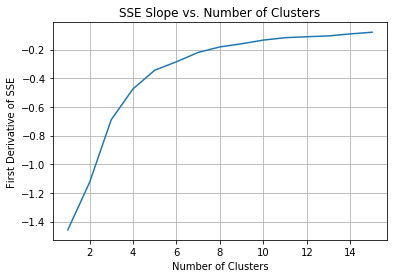

In [57]:
plt.plot(centers, np.gradient(scores)/np_azdias_scaled_pca_n.shape[0])
plt.grid(True)
plt.xlabel('Number of Clusters')
plt.ylabel('First Derivative of SSE')
plt.title('SSE Slope vs. Number of Clusters')

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

I use 8 clusters to segment the population. The plot on the panel above shows that the decline of average distance (SSE) decreased at the 8th cluster.  So elbow methon find  8  as a number of culsters. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [58]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')

In [59]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_processed,customers_outlier,_ = clean_data(customers, feat_info, df_drop_cols_sync)


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [60]:
# compare the difference between processed azdia and processed customers.
# if no different, the fit result of azdia can be used for customers.

missing_df = list(set(azdias_processed.columns) - set(customers_processed.columns)  )
print(missing_df, customers_processed.shape , azdias_processed.shape)

['GEBAEUDETYP_5.0'] (141725, 206) (798061, 207)


In [61]:
'''
The customer dataset missed a value of 5 in GEBAEUDETYP feature. 
So we need to add a column GEBAEUDETYP_5.0 with all zeros
when converted to dummy variable, we need to add a column GEBAEUDETYP_5.0 with all zeros.
Noted that this column shall be added in place as the dataframe will be converted into a matrix.
'''
for i, c in enumerate(customers_processed.columns.tolist()):
    type(c)
    if c == "GEBAEUDETYP_6.0" or c == "GEBAEUDETYP_6":
        col_position=i
        break
customers_processed.insert(col_position, "GEBAEUDETYP_5.0", np.zeros(customers_processed.shape[0]))

In [62]:
#verify insert persition of GEBAEUDETYP_6.0
for i, c in enumerate(customers_processed.columns):
    print(i,c)

0 ALTERSKATEGORIE_GROB
1 FINANZ_MINIMALIST
2 FINANZ_SPARER
3 FINANZ_VORSORGER
4 FINANZ_ANLEGER
5 FINANZ_UNAUFFAELLIGER
6 FINANZ_HAUSBAUER
7 GREEN_AVANTGARDE
8 HEALTH_TYP
9 RETOURTYP_BK_S
10 SEMIO_SOZ
11 SEMIO_FAM
12 SEMIO_REL
13 SEMIO_MAT
14 SEMIO_VERT
15 SEMIO_LUST
16 SEMIO_ERL
17 SEMIO_KULT
18 SEMIO_RAT
19 SEMIO_KRIT
20 SEMIO_DOM
21 SEMIO_KAEM
22 SEMIO_PFLICHT
23 SEMIO_TRADV
24 SOHO_KZ
25 ANZ_PERSONEN
26 ANZ_TITEL
27 HH_EINKOMMEN_SCORE
28 W_KEIT_KIND_HH
29 WOHNDAUER_2008
30 ANZ_HAUSHALTE_AKTIV
31 ANZ_HH_TITEL
32 KONSUMNAEHE
33 MIN_GEBAEUDEJAHR
34 KBA05_ANTG1
35 KBA05_ANTG2
36 KBA05_ANTG3
37 KBA05_ANTG4
38 KBA05_GBZ
39 BALLRAUM
40 EWDICHTE
41 INNENSTADT
42 GEBAEUDETYP_RASTER
43 KKK
44 MOBI_REGIO
45 ONLINE_AFFINITAET
46 REGIOTYP
47 KBA13_ANZAHL_PKW
48 PLZ8_ANTG1
49 PLZ8_ANTG2
50 PLZ8_ANTG3
51 PLZ8_ANTG4
52 PLZ8_HHZ
53 PLZ8_GBZ
54 ARBEIT
55 ORTSGR_KLS9
56 RELAT_AB
57 ANREDE_KZ_1.0
58 ANREDE_KZ_2.0
59 FINANZTYP_1.0
60 FINANZTYP_2.0
61 FINANZTYP_3.0
62 FINANZTYP_4.0
63 FINANZTYP_5.0
64 FI

In [63]:
# using previous scaler model to process dataset.
customers_scaled = scale_data(customers_processed, scaler)
# using previous pca model to transform dataset.
np_customers_scaled_pca_n = pca_n.transform(customers_scaled)
# using previous Kmean model to predict
customers_scaled_label = pd.DataFrame({"Cluster_ID": km_model_n.predict(np_customers_scaled_pca_n)})
# convert ndarray to dataframe object
df_customers_scaled_pca = pd.DataFrame(data = np_customers_scaled_pca_n, \
                                    columns = ['Dim {}'.format(i) for i in range(1,len(pca_n.components_)+1)])
#combine lable and dimensions
df_customers_scaled_pca = pd.concat([df_customers_scaled_pca, customers_scaled_label],axis = 1)
df_customers_scaled_pca.head()

,Dim 1,Dim 2,Dim 3,Dim 4,Dim 5,Dim 6,Dim 7,Dim 8,Dim 9,Dim 10,...,Dim 42,Dim 43,Dim 44,Dim 45,Dim 46,Dim 47,Dim 48,Dim 49,Dim 50,Cluster_ID
0,2.759001,-0.466884,1.036726,0.406828,-0.253251,1.002125,1.369815,-0.047389,0.265638,-0.198864,...,-0.627267,0.003069,-0.328580,-0.272403,0.484574,-0.213890,0.691246,0.265731,-0.068073,5
1,0.670257,-1.916525,-0.434934,1.145550,-1.517050,-0.492790,0.317773,0.424173,0.093326,-0.653201,...,-0.237017,0.419074,0.190689,-0.205586,0.282245,-0.188859,0.221625,-0.314650,0.539442,5
2,2.335716,0.174144,0.775019,-1.508725,0.351119,0.476864,0.184485,-0.258020,-0.502743,-0.693423,...,0.224308,0.274467,-0.207538,-0.086514,-0.057686,0.187821,-0.187855,-0.117950,-0.018127,6
3,-0.490359,0.095221,0.988816,0.422347,1.090017,-0.901564,0.357336,-0.316737,-1.145405,-0.356680,...,0.516712,0.027030,0.281009,-0.354388,-0.118517,0.131387,0.062241,-0.355251,0.509717,4
4,0.924791,-0.438239,1.417101,1.274322,-0.203005,-0.722142,0.415160,-0.109969,0.153340,0.312320,...,-0.043919,0.593214,-0.152514,0.027202,0.604645,-0.894477,-0.129613,-0.119334,-0.557852,5


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.35,1.02,'Note: Cluster 8 represents large NaN data')

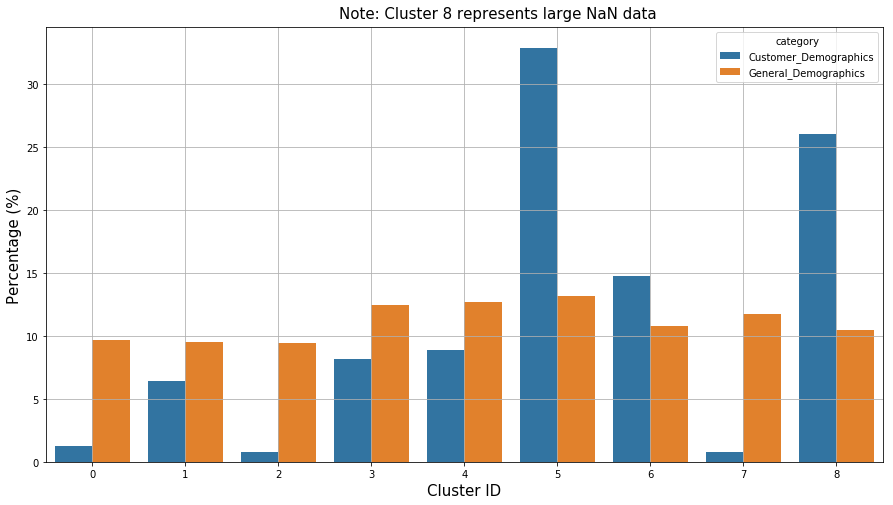

In [64]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
df_azdias_scaled_pca.loc[:,'category']='General_Demographics'
df_customers_scaled_pca.loc[:,'category'] = 'Customer_Demographics'
df_predict_label=pd.concat([df_azdias_scaled_pca,df_customers_scaled_pca])
# Count amount on each category
df_plt=df_predict_label.groupby(['category'])['Cluster_ID'].value_counts().rename('amount')
df_plt=pd.DataFrame(df_plt)
df_plt.reset_index(inplace=True)
# Generate dataset for comparation.
customers_NaN_count=customers.shape[0]-customers_processed.shape[0]
ls = [['Customer_Demographics', n_clusters, customers_NaN_count], ['General_Demographics', n_clusters, azdias_NaN_count]]
for i, (category, cluster_id, amount) in enumerate(ls):
    new_cluster = pd.Series({'category':category,'Cluster_ID': cluster_id,'amount': amount})
    df_plt = df_plt.append(new_cluster, ignore_index=True)
    
# total counts in general population and customer dataset, including the large-NaN data
cust_sum =  df_plt.loc[ df_plt.category == 'Customer_Demographics'].amount.sum( axis = 0)
genl_sum =  df_plt.loc[ df_plt.category == 'General_Demographics'].amount.sum( axis = 0)

# calculate the percentage distribution  
# df_plt.loc[:,'Percentage'] = np.where( df_plt['category']=='Customer_Demographics',  df_plt['amount']/cust_sum*100,  df_plt['amount']/genl_sum*100)
condition_c =  df_plt['category']=='Customer_Demographics'
df_plt.loc[condition_c, 'Percentage'] =  df_plt.loc[condition_c, 'amount']/cust_sum*100
condition_g =  df_plt['category']=='General_Demographics'
df_plt.loc[condition_g, 'Percentage'] =  df_plt.loc[condition_g, 'amount']/genl_sum*100
# Plot the figure for comparation 
fig = plt.figure(figsize = (15,8))
ax = sns.barplot(x='Cluster_ID', y="Percentage", hue='category', data= df_plt)
ax.set_xlabel("Cluster ID", fontsize = 15)
ax.set_ylabel("Percentage (%)", fontsize = 15)
ax.grid()
plt.annotate("Note: Cluster {} represents large NaN data".format(n_clusters), \
        xy=(0.35, 1.02), xycoords='axes fraction', fontsize = 15)

In [65]:
#The ratio of  customers to general_percent 
df_c=df_plt.loc[condition_c, ['Cluster_ID','Percentage']]
df_c.columns= ['Cluster_ID','Percentage_c']
df_g=df_plt.loc[condition_g, ['Cluster_ID','Percentage']]
df_g.columns= ['Cluster_ID','Percentage_g']
df_m= pd.merge(df_c,df_g, on='Cluster_ID') 
df_m['customers_to_general_percent'] =df_m['Percentage_c']/df_m['Percentage_g']
np_df_m=df_m.sort_values(['Cluster_ID']).values
df_m_sorted=pd.DataFrame(np_df_m, columns=df_m.columns)
df_m_sorted.head(8)

,Cluster_ID,Percentage_c,Percentage_g,customers_to_general_percent
0,0.0,1.259575,9.704888,0.129788
1,1.0,6.458581,9.533326,0.677474
2,2.0,0.743013,9.413827,0.078928
3,3.0,8.153320,12.496451,0.652451
4,4.0,8.850938,12.676205,0.698232
5,5.0,32.904431,13.164860,2.499414
6,6.0,14.763217,10.792160,1.367957
7,7.0,0.816062,11.765208,0.069362


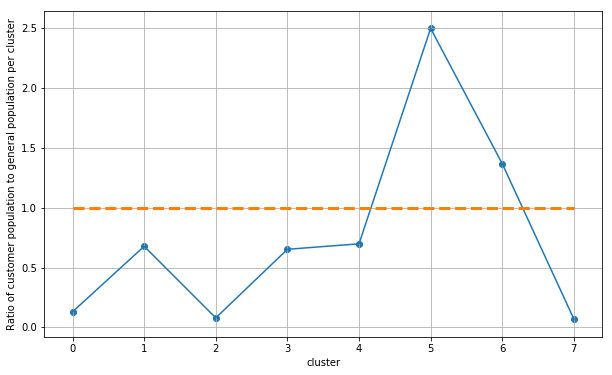

In [66]:
plt.figure(figsize=(10,6))
x=df_m_sorted.loc[:7,'Cluster_ID']
y=df_m_sorted.loc[:7,'customers_to_general_percent']
plt.plot(x,y)
plt.scatter(x,y)
t1 = np.arange(0.0, float(8), 1)
t2=np.array([1.0]*(8))
plt.plot(t1,t2,'--',linewidth=3)

plt.xticks(np.arange(0,8,1))
plt.xlabel('cluster')
plt.ylabel('Ratio of customer population to general population per cluster')
plt.grid(True)
plt.show()

In [74]:
# select one overrepresenting cluster, and one underrepresenting cluster
#According above figure , Cluster overrepresenting : 5  ;Cluster underrepresenting :7
centroid_id = [5, 7]
centroids = []
cluster_center = km_n.cluster_centers_[centroid_id,:]
np_inv_pca = pca_n.inverse_transform(cluster_center)
np_inv_scaler = scaler.inverse_transform(np_inv_pca)
df_result = pd.DataFrame(np_inv_scaler ,   columns = azdias_processed.columns, \
                         index = ['co5', 'cu7'])
# Create the dataset for overrepresenting
features=df_result.loc[ ['co5', 'cu7'],:].columns
df_cluster =pd.DataFrame(df_result.loc[ ['co5', 'cu7'],:].T.values)
df_cluster.columns=  ['co5', 'cu7']
df_cluster.insert(0, 'feature',features)

In [75]:
# Prepare the data for comparing
map_feature=df_result.columns
map_feature
df_inv_pca = pd.DataFrame(np_inv_pca ,   columns = azdias_processed.columns, \
                         index = ['co5', 'cu7'])
center_co_pca_inv = df_inv_pca.loc[ ['co5'],:].T.values.reshape(-1,)
center_cu_pca_inv = df_inv_pca.loc[ ['cu7'],:].T.values.reshape(-1,)

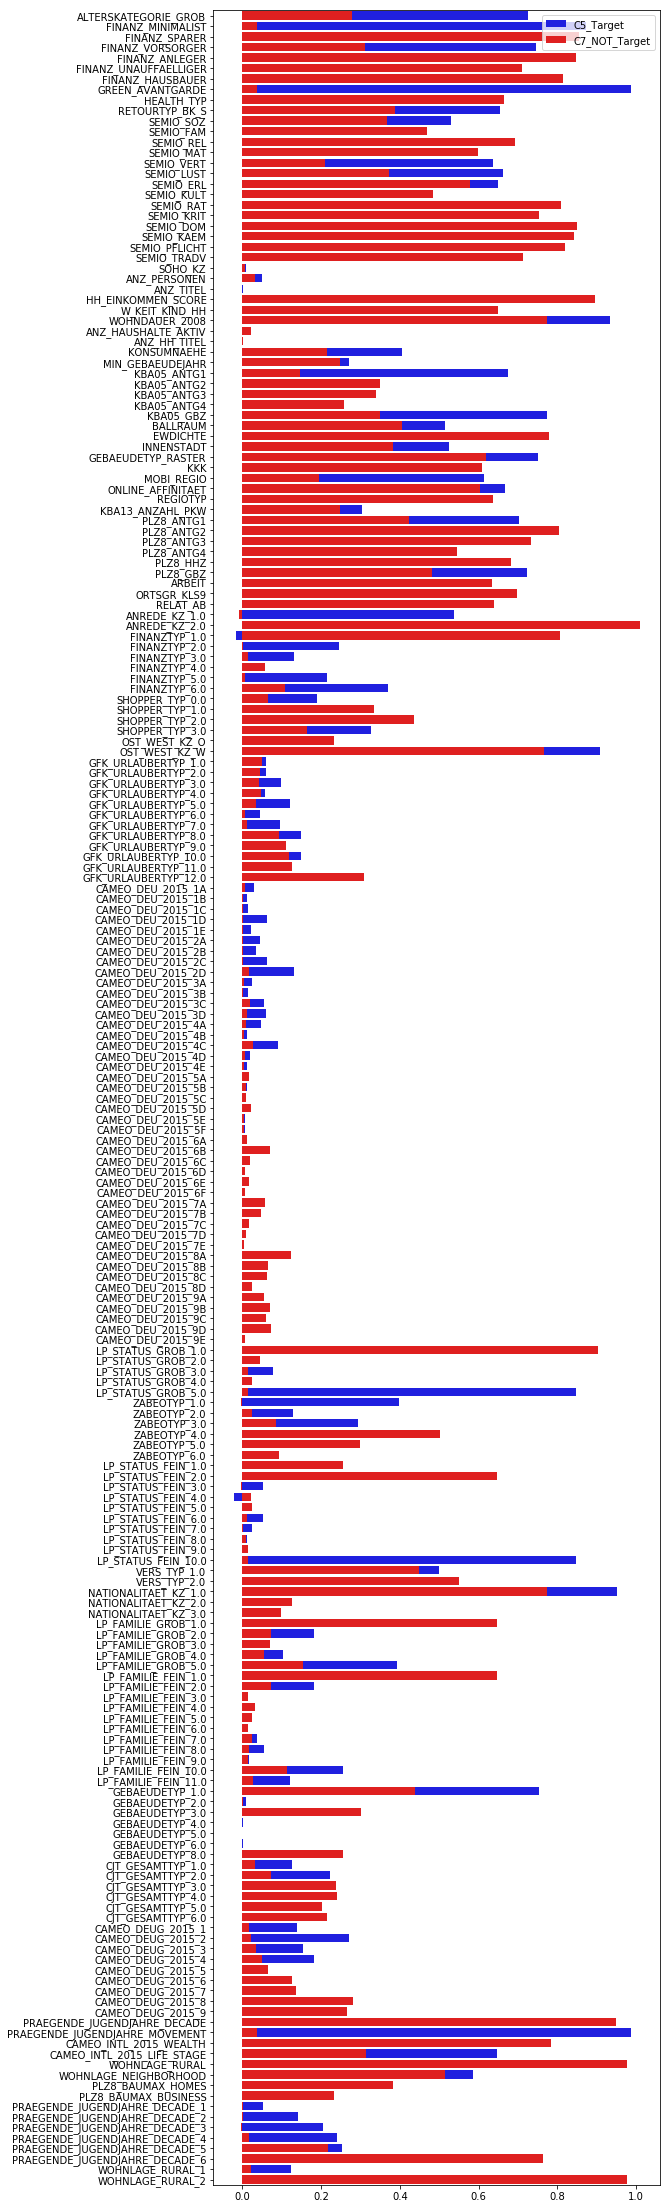

In [76]:
#comparing center C6 (good target) and center C4 (bad target), did not reverse the scaler since plotting won't be clear in actual unit

plt.figure(figsize=(8,40))
sns.barplot(x=center_co_pca_inv, y=map_feature,label="C5_Target", color="blue")
sns.barplot(x=center_cu_pca_inv, y=map_feature,label="C7_NOT_Target", color="red")
          
plt.legend(loc="upper right")

In [77]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# According above figure, Select the following features
overrepresent = [['ALTERSKATEGORIE_GROB','Estimated age based on given name analysis:3: 46 - 60 years old'],
['FINANZ_MINIMALIST','low financial interest (MINIMALIST) -  4: low'],
['FINANZ_VORSORGER','FINANCIAL PRECEDENT;4: low'],
['GREEN_AVANTGARDE','Membership in environmental sustainability as part of youth:1: member of green avantgarde'],
['SEMIO_VERT','Personality typology; low affinity;'],
['ANZ_PERSONEN','Number of adults in household:> 2'],
['KBA05_ANTG1','Number of 1-2 family houses in the microcell; 3: high share of 1-2 family homes'],
['KBA05_GBZ','Number of buildings in the microcell:4: 17-22 buildings'],
['MOBI_REGIO','Movement patterns:4: low movement'],
['PLZ8_ANTG1','Number of 1-2 family houses in the PLZ8 region:3: high share of 1-2 family homes'],
['CJT_GESAMTTYP_2.0','Customer-Journey-Typology: preferred information and buying channels for  consumer:2: Advertising- and Consumptiontraditionalist'],
['LP_FAMILIE_GROB_2.0','Family type; rough scale 2: couple (maps to 2 in fine scale)'],
['LP_FAMILIE_GROB_5.0','Family type; rough scale 5: multiperson household (maps to 9-11 in fine scale)'],
['LP_STATUS_FEIN_10.0','Social status; fine scale 10: top earners'],
['LP_FAMILIE_FEIN_10.0','Family type; fine scale  10: two-generational household'],
['ANREDE_KZ_1.0','1: male'],
['LP_STATUS_GROB_5.0','Social status; rough scale：5: top earners (maps to 10 in fine scale)'],
['CAMEO_DEU_2015_2D','German CAMEO: Wealth / Life Stage Typology; detailed scale  2D: Fine Management'],
['CAMEO_DEUG_2015_2','German CAMEO: Wealth / Life Stage Typology; rough scale 2: upper middleclass'],
['OST_WEST_KZ_W','Western Germany'],
['ZABEOTYP_1.0','Energy consumption typology   1: green'],
['GFK_URLAUBERTYP_5.0','Vacation habits 5: Nature fans'],
['FINANZTYP_5.0','Most descriptive financial type for individual 6: Investor'],
['FINANZTYP_6.0','Most descriptive financial type for individual 6: inconspicuous (UNAUFFAELLIGER)'],
['SHOPPER_TYP_0.0','0: external supplied hedonists'],
['PRAEGENDE_JUGENDJAHRE_MOVEMENT','Dominating movement of person\'s youth (1 avantgarde )'],
['CAMEO_INTL_2015_LIFE_STAGE','Older Families &  Mature Couples'],
['WOHNLAGE_RURAL_1','Neighborhood quality (or rural flag) Rural'],
['PRAEGENDE_JUGENDJAHRE_DECADE_3',' 60s - generation 68 / student protestors (Avantgarde; W)  or opponents to the building of the Wall (Avantgarde; E)'],
['PRAEGENDE_JUGENDJAHRE_DECADE_4','70s -  peace movement (Avantgarde; E+W)']]
print("The cluster that is overrepresented in the  customer data ")
df_op=pd.DataFrame(overrepresent,columns=['feature','meaning'])
df_op_cluster=pd.merge(df_op,df_cluster, on = 'feature')
pd.set_option('display.max_colwidth',100)
df_op_cluster.head(35)



The cluster that is overrepresented in the  customer data 


,feature,meaning,co5,cu7
0,ALTERSKATEGORIE_GROB,Estimated age based on given name analysis:3: 46 - 60 years old,3.177886,1.838114
1,FINANZ_MINIMALIST,low financial interest (MINIMALIST) - 4: low,4.488613,1.144514
2,FINANZ_VORSORGER,FINANCIAL PRECEDENT;4: low,3.980776,2.247131
3,GREEN_AVANTGARDE,Membership in environmental sustainability as part of youth:1: member of green avantgarde,0.986546,0.037176
4,SEMIO_VERT,Personality typology; low affinity;,4.811707,2.264415
5,ANZ_PERSONEN,Number of adults in household:> 2,2.278839,1.453427
6,KBA05_ANTG1,Number of 1-2 family houses in the microcell; 3: high share of 1-2 family homes,2.695594,0.590025
7,KBA05_GBZ,Number of buildings in the microcell:4: 17-22 buildings,4.093964,2.397137
8,MOBI_REGIO,Movement patterns:4: low movement,4.066570,1.975464
9,PLZ8_ANTG1,Number of 1-2 family houses in the PLZ8 region:3: high share of 1-2 family homes,2.806750,1.691411


In [78]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# According above figure, Select the following features
underrepresent = [['FINANZ_SPARER','money saver: 4: low'],
['FINANZ_ANLEGER','FINANCE INVESTOR: low'],
['FINANZ_HAUSBAUER','home ownership (HAUSBAUER) - low'],
['HH_EINKOMMEN_SCORE','Estimated household net income: 5 low'],
['ANZ_HAUSHALTE_AKTIV','Number of households in the building: 12'],
['KBA05_ANTG3','Number of 6-10 family houses in the microcell -  1: lower share of 6-10 family homes in the microcell'],
['KBA05_ANTG4','Number of 10+ family houses in the microcell-  1: lower share of 10+ family homes'],
['LP_STATUS_FEIN_2.0','Social status; fine scale -  2: orientation-seeking low-income earners'],
['NATIONALITAET_KZ_3.0','Nationality based on given name analysis:-  3: assimilated names'],
['LP_STATUS_GROB_1.0','Social status; rough scale - 1: low-income earners (maps to 1-2 in fine scale)'],
['CAMEO_DEU_2015_8A','German CAMEO: Wealth / Life Stage Typology; detailed scale - 8A: Multi-culteral'],
['CAMEO_DEUG_2015_8','German CAMEO: Wealth / Life Stage Typology; rough scale -  8: working class'],
['CAMEO_DEUG_2015_9','German CAMEO: Wealth / Life Stage Typology; rough scale -  9: urban working class'],
['ZABEOTYP_5.0','Energy consumption typolog-  5: seeking orientation'],
['FINANZTYP_1.0','Most descriptive financial type for individual -  1: low financial interest (MINIMALIST)'],
['SHOPPER_TYP_2.0','family shoper'],
['CAMEO_INTL_2015_WEALTH',' Less Affluent Households '],
['PLZ8_BAUMAX_BUSINESS','Most common building type within the PLZ8 region -  5: mainly business buildings'],
['PRAEGENDE_JUGENDJAHRE_DECADE_6','90s - digital media kids or ecological awareness  ']]
print("The cluster that is underrepresented in the  customer data ")
df_up=pd.DataFrame(underrepresent,columns=['feature','meaning'])
df_up_cluster=pd.merge(df_up,df_cluster, on = 'feature')
pd.set_option('display.max_colwidth',100)
df_up_cluster.head(35)

The cluster that is underrepresented in the  customer data 


,feature,meaning,co5,cu7
0,FINANZ_SPARER,money saver: 4: low,1.862051,4.419625
1,FINANZ_ANLEGER,FINANCE INVESTOR: low,1.993495,4.385171
2,FINANZ_HAUSBAUER,home ownership (HAUSBAUER) - low,1.976192,4.252798
3,HH_EINKOMMEN_SCORE,Estimated household net income: 5 low,2.384113,5.473375
4,ANZ_HAUSHALTE_AKTIV,Number of households in the building: 12,1.491884,13.434185
5,KBA05_ANTG3,Number of 6-10 family houses in the microcell - 1: lower share of 6-10 family homes in the micr...,0.022400,1.019678
6,KBA05_ANTG4,Number of 10+ family houses in the microcell- 1: lower share of 10+ family homes,0.005191,0.517567
7,LP_STATUS_FEIN_2.0,Social status; fine scale - 2: orientation-seeking low-income earners,0.019184,0.647419
8,NATIONALITAET_KZ_3.0,Nationality based on given name analysis:- 3: assimilated names,0.016009,0.099202
9,LP_STATUS_GROB_1.0,Social status; rough scale - 1: low-income earners (maps to 1-2 in fine scale),0.019496,0.902056


In [72]:
pd.set_option('display.max_colwidth',50)

In [82]:
#In section 1.1.3,I found a qualitatively different cluster
# Compare ouliers
print('Outlier by assessed missing data in each row (cluster -1)\n')
print('Population: {}'.format(len(azdias_outlier)))
print('Percentage for the total: {:.2f}%\n'.format(len(azdias_outlier) / len(azdias) *100.))
print('Customer: {}'.format(len(customers_outlier)))
print('Percentage for the total: {:.2f}%\n'.format(len(customers_outlier) / len(customers) * 100.))

Outlier by assessed missing data in each row (cluster -1)

Population: 93160
Percentage for the total: 10.45%

Customer: 49927
Percentage for the total: 26.05%



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

I use elbow method to select 8 clusters and analyze the dataset via PCA method and find out 50 principle components based on 8 clusters. I calculate the percentage on each cluster id for the customer dataset and general dataset. and then get the ratio of customer to general population.
The value 1 is threshold. If above 1.0 the cluster may be target audience of mail-order. If the reatio with below 1.0 is not. Since used 8 clusters, the customer data for some of the clusters had low population and eventhough they were below 1.0 threshold.  I draw a chart and I find that the most overrepresented cluser id is 6 and underrepresented cluster id is 4 among 8 clusters. I select them to do further analysis.

The 6 cluster id has these features that are popular with mail-order company :
  - age
      -  Estimated age about 46 - 60 years old
      -  Their youth has dominating avantgarde movement 
      -  They are 60s - generation 68 / student protestors , opponents to the building of the Wall  or 70s - peace movement  
   - gender	
      - male
   - consumption	
      -  preferred information and buying channels for  consumer: Advertising- and Consumptiontraditionalist
      -  Their Vacation habits is  Nature fans and they are external supplied hedonists
  - Family type
      -  they have more than 2 adults or more in household, or they are couple.
      -  they often have two-generational household
      -  They are Older Families &  Mature Couples
  - income	
      - They are not low financial interest and have high share of 1-2 family homes.
      - They are top earners and upper middleclass but have fine management for shopping
      - They are investor and inconspicuous.
  - location	
      - They often stay at  17-22 buildings in the microcell
      - They have high share of 1-2 family homes in the PLZ8 region
      -  they are Western Germany and stay at rual.
  - Movement	
      -  They are member of green avantgarde in environmental sustainability as part of youth
      -  They like green energy consuption and low movement
  - Their personality is low affinity;

Cluser ID 4 stands out underrepresented in the customer data.  it includes the following features that are unpopular with mail-order company :
  - age	 
    - They are 90s - digital media kids  
  - income	 
    - They are low probability of finance investor and  money saver.
    - They are most likely not home owner 
    - They are estimate low household net income and are orientation-seeking low-income earners or low-income earners. 
    - They are working class or urban working class and need low financial interest (MINIMALIST)
    - They are from Less Affluent Households 
  - location	
    - They more likely have lots of households in the building 
    - They have lower share of 6-10/10+ family houses in the microcell 
    - They usually stay mainly business buildings within the PLZ8 region
  - movement	
    -  Their energy consumption typolog is seeking orientation
  - Personality 	
    - They are family shoper and  Multi-culteral, They have	assimilated names  
    
In section 1.1.3 about the outlier by assessed missing data in each row named cluster -1, percentage for population is 10.45% , and the percentage for customer is 26.05%. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.